In [520]:
import pandas as pd
merged_df = pd.read_csv('merged_outcomes_intakes.csv')

In [521]:
merged_df.shape

(135235, 12)

In [522]:
merged_df.head(10)

,animal_id,name,sex_upon_intake,age_upon_intake,datetime_intake,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type
0,A006100,Scamp,Neutered Male,10 years,2017-12-07 14:07:00,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner
1,A047759,Oreo,Neutered Male,10 years,2014-04-02 15:55:00,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer
2,A134067,Bandit,Neutered Male,16 years,2013-11-16 09:02:00,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner
3,A141142,Bettie,Spayed Female,15 years,2013-11-16 14:46:00,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner
4,A163459,Sasha,Intact Female,15 years,2014-11-14 15:11:00,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner
5,A165752,Pep,Neutered Male,15 years,2014-09-15 11:28:00,1,Stray,Normal,Dog,Lhasa Apso Mix,Brown/White,Return to Owner
6,A178569,Boti,Neutered Male,15 years,2014-03-17 09:45:00,1,Public Assist,Normal,Dog,Shetland Sheepdog Mix,White/Black,Return to Owner
7,A189592,Ophelia,Spayed Female,18 years,2015-09-18 17:46:00,1,Stray,Normal,Dog,Shetland Sheepdog Mix,Brown/White,Return to Owner
8,A191351,Bri-Bri,Intact Female,16 years,2015-11-13 15:57:00,1,Stray,Normal,Cat,Domestic Longhair Mix,Black/White,Return to Owner
9,A197810,Sassafrass,Spayed Female,14 years,2014-12-08 12:30:00,1,Stray,Normal,Cat,American Shorthair Mix,Brown Tabby/White,Transfer


In [523]:
merged_df.columns

Index(['animal_id', 'name', 'sex_upon_intake', 'age_upon_intake',
       'datetime_intake', 'visit_count', 'intake_type', 'intake_condition',
       'animal_type', 'breed', 'color', 'outcome_type'],
      dtype='object')

In [524]:
print(merged_df.isnull().sum())

# name - 38897 missing values - ~28.7%
# sex_upon_intake - 1 missing value - Club in Unknown category
# outcome_type - 25 missing values - Create a new Unknown category for it

animal_id               0
name                38897
sex_upon_intake         1
age_upon_intake         0
datetime_intake         0
visit_count             0
intake_type             0
intake_condition        0
animal_type             0
breed                   0
color                   0
outcome_type           25
dtype: int64


In [525]:
merged_df['sex_upon_intake'].value_counts()

sex_upon_intake
Intact Male      46904
Intact Female    46356
Neutered Male    19620
Spayed Female    16751
Unknown           5603
Name: count, dtype: int64

In [526]:
merged_df['sex_upon_intake'] = merged_df['sex_upon_intake'].fillna("Unknown")

In [527]:
merged_df['sex_upon_intake'].value_counts()

sex_upon_intake
Intact Male      46904
Intact Female    46356
Neutered Male    19620
Spayed Female    16751
Unknown           5604
Name: count, dtype: int64

In [528]:
merged_df['outcome_type'] = merged_df['outcome_type'].fillna("Unknown")

In [529]:
merged_df['outcome_type'].value_counts()

outcome_type
Adoption           64328
Transfer           44280
Return to Owner    19631
Euthanasia          4592
Died                1178
Rto-Adopt            897
Disposal             239
Missing               54
Unknown               25
Relocate               8
Stolen                 2
Lost                   1
Name: count, dtype: int64

In [530]:
print(merged_df.isnull().sum())

animal_id               0
name                38897
sex_upon_intake         0
age_upon_intake         0
datetime_intake         0
visit_count             0
intake_type             0
intake_condition        0
animal_type             0
breed                   0
color                   0
outcome_type            0
dtype: int64


In [531]:
# Define the main categories we want to keep
main_outcomes = {
    "Adoption": "Adoption",
    "Rto-Adopt": "Adoption",   # merge into Adoption
    "Transfer": "Transfer",
    "Return to Owner": "Return to Owner",
    "Euthanasia": "Euthanasia",
    "Died": "Died",
    "Unknown": "Unknown"       # keep Unknown explicitly
}

# Map outcomes: keep the main ones, everything else -> "Other"
merged_df["outcome_type"] = merged_df["outcome_type"].map(
    lambda x: main_outcomes.get(x, "Other")
)

# Double check distribution
print(merged_df["outcome_type"].value_counts())


outcome_type
Adoption           65225
Transfer           44280
Return to Owner    19631
Euthanasia          4592
Died                1178
Other                304
Unknown               25
Name: count, dtype: int64


In [532]:
# Outcome Type Definitions (Austin Animal Center dataset)
#
# Adoption (65,225) 
#   - Animal was adopted into a new home from the shelter.
#
# Transfer (44,280) 
#   - Animal was moved to another organization (rescue, foster group, partner shelter).
#
# Return to Owner (19,631) 
#   - Lost pet was reunited with its original owner.
#
# Euthanasia (4,592) 
#   - Animal was humanely put down (severe illness, aggression, overcrowding).
#
# Died (1,178) 
#   - Animal died naturally while in shelter care (not euthanized).
#
# Other - Disposal 239,Missing 54, Relocate 8, Stolen 2, Lost 1

In [533]:
# Has Name - 1, else 0

import pandas as pd
import re

def has_valid_name(name: str) -> int:
    """
    Return 1 if name looks like a valid given name, else 0.
    Implements the user-specified rules:
    - No digits, #, $, (, )
    - Length > 1
    - Not empty, NaN, or placeholders
    - Not generic group labels
    - Names starting with '*' are allowed
    """

    # Handle missing or NaN
    if pd.isna(name):
        return 0

    name_str = str(name).strip()
    if name_str == "" or name_str.isspace():
        return 0

    name_lower = name_str.lower()
        
    # if length <= 2 - return 0
    if len(name_lower) <= 2 :
        return 0
        
    # Preserve '*' names
    if name_str.startswith("*"):
        return 1

    # Rule 1: No numbers
    if any(char.isdigit() for char in name_lower):
        return 0

    # Rule 2: No # or $
    if "#" in name_lower or "$" in name_lower:
        return 0

    # Rule 3: No ( or )
    if "(" in name_lower or ")" in name_lower:
        return 0

    # Rule 4 & 5: invalid placeholders / generic labels
    invalid_terms = {
        "unknown", "unnamed", "no name", "nameless", "not named", "none",
        "stray", "animal", "dog", "puppy", "cat", "kitten",
        "male", "female", "litter", "deceased"
    }
    if name_lower in invalid_terms:
        return 0

    return 1

# Example usage:
# df["HasName"] = df["Name"].apply(has_valid_name)


In [534]:
# Applying this function to the name column:
merged_df["HasName"] = merged_df["name"].apply(has_valid_name)

In [535]:
merged_df

,animal_id,name,sex_upon_intake,age_upon_intake,datetime_intake,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName
0,A006100,Scamp,Neutered Male,10 years,2017-12-07 14:07:00,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,1
1,A047759,Oreo,Neutered Male,10 years,2014-04-02 15:55:00,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer,1
2,A134067,Bandit,Neutered Male,16 years,2013-11-16 09:02:00,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner,1
3,A141142,Bettie,Spayed Female,15 years,2013-11-16 14:46:00,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner,1
4,A163459,Sasha,Intact Female,15 years,2014-11-14 15:11:00,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135230,A929598,NaN,Unknown,4 days,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0
135231,A929599,NaN,Unknown,4 days,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0
135232,A929600,NaN,Unknown,4 days,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0
135233,A929602,NaN,Unknown,1 year,2025-05-02 12:22:00,1,Stray,Normal,Cat,Domestic Shorthair,Black,Transfer,0


In [536]:
import pandas as pd
import re

def clean_and_parse_age_days(df, col="age_upon_intake"):
    """
    Clean anomalies, fix plural issues, and parse age_upon_intake into age_days.
    
    Steps:
    1. Drop anomalies with negative ages.
    2. Normalize plurals like '1 years' -> '1 year', '1 weeks' -> '1 week'.
    3. Convert all ages to days (integer).
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    col : str
        Column name containing age strings.
    
    Returns
    -------
    df : pd.DataFrame
        Dataframe with new column:
        - age_days
    """
    
    # Drop negative anomalies
    df = df[~df[col].astype(str).str.contains("-", na=False)].copy()
    
    # Fix plural issues for "1 unit"
    fixes = {
        r"\b1 years\b": "1 year",
        r"\b1 months\b": "1 month",
        r"\b1 weeks\b": "1 week",
        r"\b1 days\b": "1 day"
    }
    for wrong, right in fixes.items():
        df[col] = df[col].str.replace(wrong, right, regex=True)
    
    # Unit to days mapping
    unit_to_days = {"day": 1, "week": 7, "month": 30, "year": 365}
    
    def parse_age(age_str):
        if pd.isna(age_str) or str(age_str).strip() == "":
            return None
        match = re.match(r"(\d+)\s+(\w+)", str(age_str).lower())
        if not match:
            return None
        value, unit = int(match.group(1)), match.group(2).rstrip("s")
        return value * unit_to_days.get(unit, None)
    
    # Apply parser
    df["age_days"] = df[col].apply(parse_age)
    
    return df


In [537]:
merged_df = clean_and_parse_age_days(merged_df, col="age_upon_intake")

In [538]:
merged_df

,animal_id,name,sex_upon_intake,age_upon_intake,datetime_intake,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days
0,A006100,Scamp,Neutered Male,10 years,2017-12-07 14:07:00,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,1,3650
1,A047759,Oreo,Neutered Male,10 years,2014-04-02 15:55:00,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer,1,3650
2,A134067,Bandit,Neutered Male,16 years,2013-11-16 09:02:00,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner,1,5840
3,A141142,Bettie,Spayed Female,15 years,2013-11-16 14:46:00,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner,1,5475
4,A163459,Sasha,Intact Female,15 years,2014-11-14 15:11:00,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner,1,5475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135230,A929598,NaN,Unknown,4 days,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4
135231,A929599,NaN,Unknown,4 days,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4
135232,A929600,NaN,Unknown,4 days,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4
135233,A929602,NaN,Unknown,1 year,2025-05-02 12:22:00,1,Stray,Normal,Cat,Domestic Shorthair,Black,Transfer,0,365


In [539]:
merged_df = merged_df.drop(columns=["name", "age_upon_intake"])

In [540]:
import pandas as pd
merged_df['datetime_intake'] = pd.to_datetime(merged_df['datetime_intake'])

In [541]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days'],
      dtype='object')

In [542]:
merged_df = merged_df.reset_index(drop=True)
merged_df

,animal_id,sex_upon_intake,datetime_intake,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days
0,A006100,Neutered Male,2017-12-07 14:07:00,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,1,3650
1,A047759,Neutered Male,2014-04-02 15:55:00,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer,1,3650
2,A134067,Neutered Male,2013-11-16 09:02:00,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner,1,5840
3,A141142,Spayed Female,2013-11-16 14:46:00,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner,1,5475
4,A163459,Intact Female,2014-11-14 15:11:00,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner,1,5475
...,...,...,...,...,...,...,...,...,...,...,...,...
135226,A929598,Unknown,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4
135227,A929599,Unknown,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4
135228,A929600,Unknown,2025-05-02 12:22:00,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4
135229,A929602,Unknown,2025-05-02 12:22:00,1,Stray,Normal,Cat,Domestic Shorthair,Black,Transfer,0,365


# Creating new features for datetime and visualizing them:

In [543]:
import pandas as pd

merged_df['datetime_intake'] = pd.to_datetime(merged_df['datetime_intake'])

# Month - Categorical
merged_df['intake_month'] = merged_df['datetime_intake'].dt.month_name()

# Day of Week (full name) - Categorical
merged_df['intake_weekday'] = merged_df['datetime_intake'].dt.day_name()

# Week Number of Year - Don't feed to model
merged_df['intake_week'] = merged_df['datetime_intake'].dt.isocalendar().week

# Hour of the Day - Don't feed to the model
merged_df['intake_hour'] = merged_df['datetime_intake'].dt.hour

# Quarter of the Year - Categorical
merged_df['intake_quarter'] = merged_df['datetime_intake'].dt.quarter

# Weekend flag with string weekdays - Categorical
merged_df['is_weekend'] = merged_df['intake_weekday'].apply(
    lambda x: "Weekend" if x in ["Saturday", "Sunday"] else "Weekday"
)

# Season (Winter, Spring, Summer, Fall) - Categorical
def get_season(month_name):
    if month_name in ['December', 'January', 'February']:
        return "Winter"
    elif month_name in ['March', 'April', 'May']:
        return "Spring"
    elif month_name in ['June', 'July', 'August']:
        return "Summer"
    else:
        return "Fall"

merged_df['intake_season'] = merged_df['intake_month'].apply(get_season)

# AM/PM - Categorical
merged_df['intake_am_pm'] = merged_df['intake_hour'].apply(lambda x: "AM" if x < 12 else "PM")

# Part of the Day - Categorical
def part_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"
merged_df['intake_part_of_day'] = merged_df['intake_hour'].apply(part_of_day)

In [544]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day'],
      dtype='object')

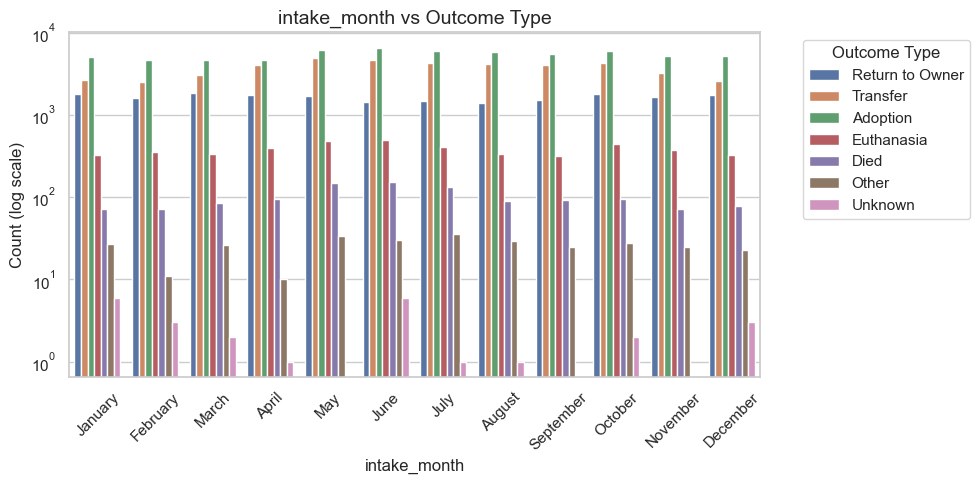

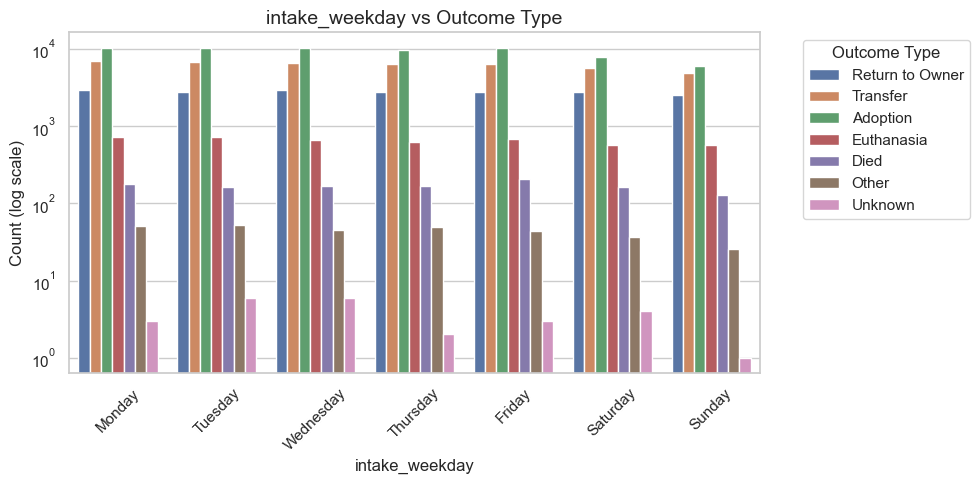

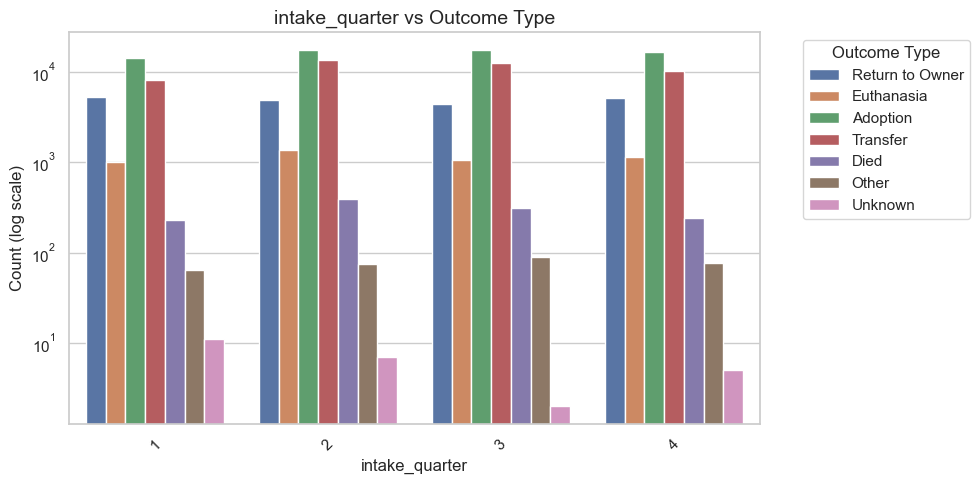

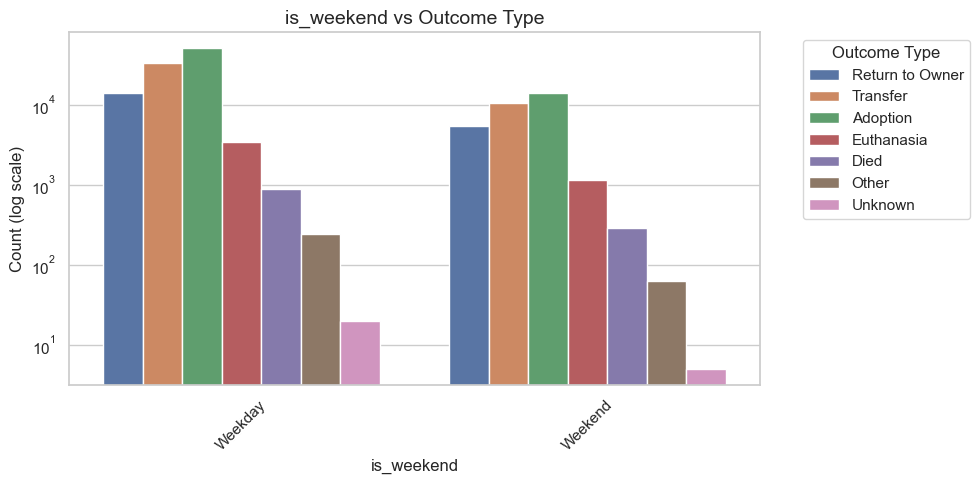

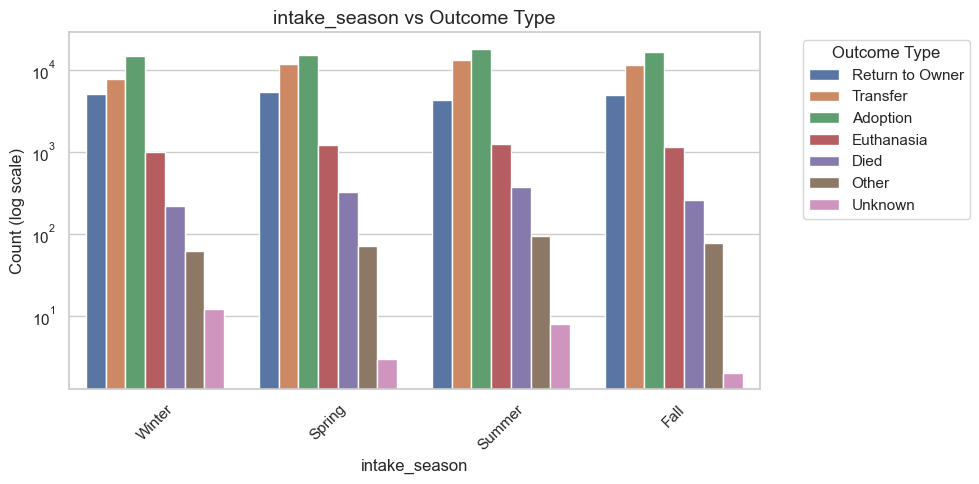

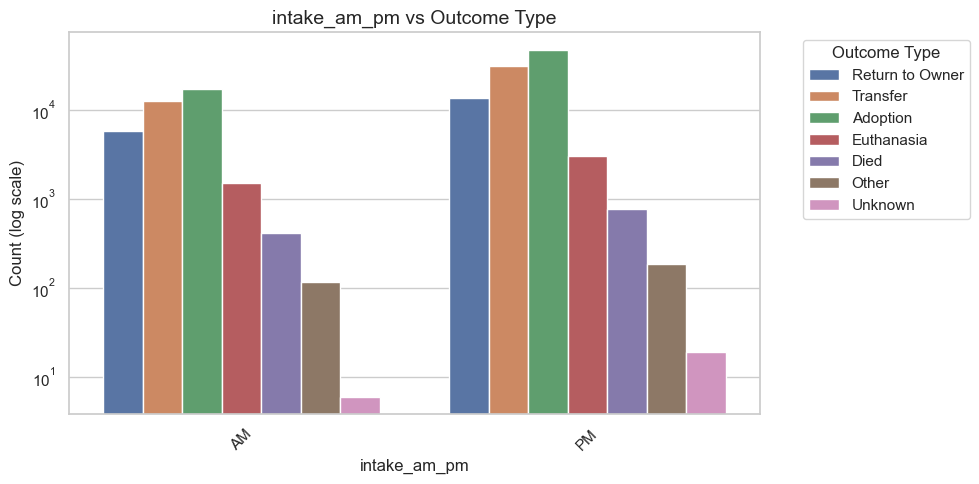

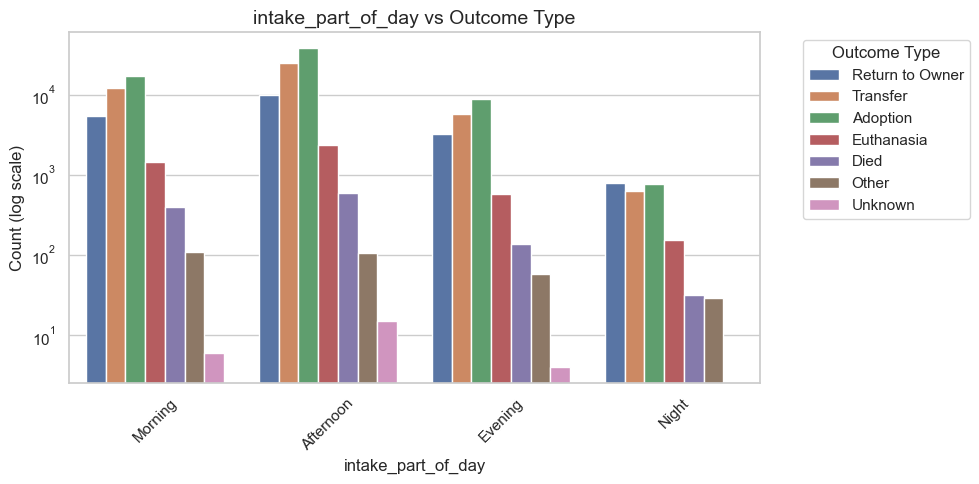

In [545]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define natural orderings
month_order = [
    "January","February","March","April","May","June",
    "July","August","September","October","November","December"
]
weekday_order = [
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"
]
quarter_order = [1, 2, 3, 4]
weekend_order = ["Weekday","Weekend"]
season_order = ["Winter","Spring","Summer","Fall"]
ampm_order = ["AM","PM"]
partofday_order = ["Morning","Afternoon","Evening","Night"]

# Map features to their order
orders = {
    "intake_month": month_order,
    "intake_weekday": weekday_order,
    "intake_quarter": quarter_order,
    "is_weekend": weekend_order,
    "intake_season": season_order,
    "intake_am_pm": ampm_order,
    "intake_part_of_day": partofday_order
}

sns.set(style="whitegrid")

# Loop through features
for col in orders.keys():
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(
        data=merged_df,
        x=col,
        hue="outcome_type",
        order=orders[col]  # use natural order
    )
    plt.title(f"{col} vs Outcome Type", fontsize=14)
    plt.xticks(rotation=45)
    plt.yscale("log")   # natural log scale
    plt.ylabel("Count (log scale)")
    plt.legend(title="Outcome Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [546]:
# For EDA:

# describe method - DONE
# histogram - DONE
# log histogram - DONE
# value_counts - DONE
# horizontal bar plot (Count and frequency) 
# scatter plot and heatmaps
# Stacked bar plots
# Multi class histograms
# Box plot
# violin plot
# scatter matrix
# pairplot - DONE
# nnique - DONE



# Vizualizing Breed:

In [547]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [548]:
import seaborn as sns

# ---------- Setup ----------
plt.rcParams["figure.figsize"] = (12, 8)
sns.set(style="whitegrid")

In [549]:
import re
import numpy as np
import pandas as pd

# ---------- BREED SIMPLIFICATION ----------
# 1) Remove trailing " Mix" (case-insensitive, exact word before end)
def clean_breed(b):
    if pd.isna(b):
        return np.nan
    s = str(b)
    # remove ' Mix' at end (case-insensitive)
    s = re.sub(r'\s+Mix$', '', s, flags=re.IGNORECASE)
    # keep only first breed before '/'
    s = s.split('/')[0].strip()
    return s

# Apply to merged_df
merged_df['Simple_breed'] = merged_df['breed'].apply(clean_breed)

# Get counts of simplified breeds
breed_counts = merged_df['Simple_breed'].value_counts()

# Replace breeds with count < 10 by "Rare"
merged_df['Simple_breed'] = merged_df['Simple_breed'].apply(
    lambda x: "Rare" if pd.notna(x) and breed_counts[x] < 10 else x
)

# Quick check
print(merged_df['Simple_breed'].value_counts().head(20))


Simple_breed
Domestic Shorthair       49140
Labrador Retriever       10908
Pit Bull                 10874
Chihuahua Shorthair       8757
German Shepherd           5568
Domestic Medium Hair      4595
Australian Cattle Dog     2525
Domestic Longhair         2143
Dachshund                 1838
Siamese                   1747
Siberian Husky            1617
Boxer                     1452
Border Collie             1413
Great Pyrenees            1305
Miniature Poodle          1204
Yorkshire Terrier         1054
Australian Shepherd       1046
Catahoula                  977
Beagle                     972
Miniature Schnauzer        917
Name: count, dtype: int64


In [550]:
merged_df[merged_df['Simple_breed']=='Rare']

,animal_id,sex_upon_intake,datetime_intake,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,...,intake_month,intake_weekday,intake_week,intake_hour,intake_quarter,is_weekend,intake_season,intake_am_pm,intake_part_of_day,Simple_breed
0,A006100,Neutered Male,2017-12-07 14:07:00,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,...,December,Thursday,49,14,4,Weekday,Winter,PM,Afternoon,Rare
143,A348400,Spayed Female,2017-07-17 13:09:00,1,Stray,Normal,Cat,Scottish Fold Mix,Black/White,Adoption,...,July,Monday,29,13,3,Weekday,Summer,PM,Afternoon,Rare
589,A498745,Spayed Female,2020-08-31 07:46:00,1,Stray,Injured,Dog,Wolf Hybrid Mix,White/Gray,Euthanasia,...,August,Monday,36,7,3,Weekday,Summer,AM,Morning,Rare
836,A531394,Neutered Male,2015-04-21 16:59:00,1,Stray,Normal,Dog,Dachshund Stan Mix,Black/Tan,Adoption,...,April,Tuesday,17,16,2,Weekday,Spring,PM,Afternoon,Rare
858,A533106,Intact Male,2014-07-02 17:29:00,1,Stray,Normal,Dog,Podengo Pequeno Mix,Black/White,Adoption,...,July,Wednesday,27,17,3,Weekday,Summer,PM,Evening,Rare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133003,A920788,Intact Female,2025-01-04 11:36:00,1,Owner Surrender,Normal,Dog,Kangal Mix,Cream,Adoption,...,January,Saturday,1,11,1,Weekend,Winter,AM,Morning,Rare
133686,A923553,Intact Male,2025-02-04 14:15:00,1,Stray,Normal,Dog,Otterhound Mix,Black/Brown,Euthanasia,...,February,Tuesday,6,14,1,Weekday,Winter,PM,Afternoon,Rare
133729,A923736,Spayed Female,2025-02-06 12:36:00,1,Owner Surrender,Normal,Dog,Belgian Tervuren,Black/White,Adoption,...,February,Thursday,6,12,1,Weekday,Winter,PM,Afternoon,Rare
133858,A924587,Intact Female,2025-02-12 13:17:00,1,Owner Surrender,Normal,Cat,Bombay,Black,Adoption,...,February,Wednesday,7,13,1,Weekday,Winter,PM,Afternoon,Rare


In [551]:
merged_df['Simple_breed'].nunique()

187

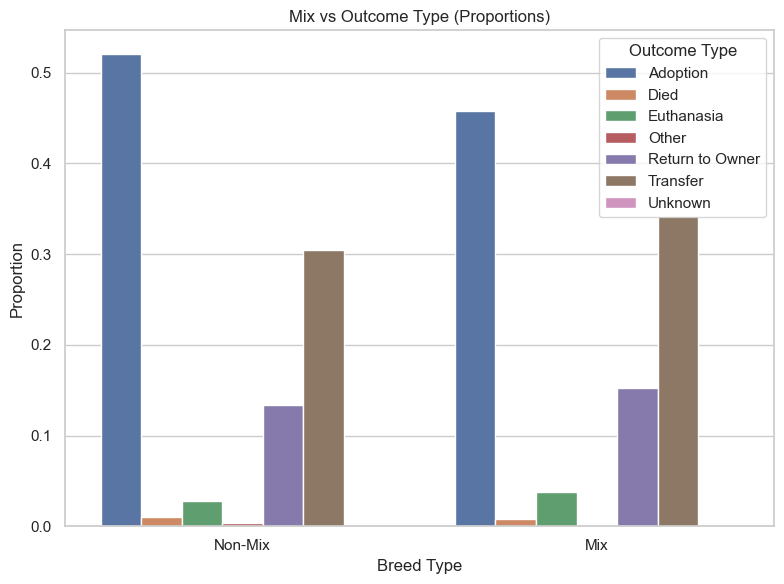

In [552]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add flag column: 1 if "Mix" in breed, else 0
merged_df['IsMix'] = merged_df['breed'].str.contains("Mix", case=False, na=False).astype(int)

# Compute counts
mix_counts = (
    merged_df
    .groupby(["IsMix", "outcome_type"])
    .size()
    .reset_index(name="count")
)

# Compute proportions within each IsMix group
mix_counts["proportion"] = mix_counts.groupby("IsMix")["count"].transform(lambda x: x / x.sum())

# Plot proportions
plt.figure(figsize=(8,6))
sns.barplot(x="IsMix", y="proportion", hue="outcome_type", data=mix_counts)
plt.title("Mix vs Outcome Type (Proportions)")
plt.xticks([0,1], ["Non-Mix", "Mix"])
plt.xlabel("Breed Type")
plt.ylabel("Proportion")
plt.legend(title="Outcome Type")
plt.tight_layout()
plt.show()

In [553]:
merged_df['IsMix'].value_counts()

IsMix
1    82676
0    52555
Name: count, dtype: int64

In [554]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix'],
      dtype='object')

In [555]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- BREED COARSENING ----------
# threshold >800 => keep, else "Exotic"
popular_threshold = 800
breed_counts = merged_df['Simple_breed'].value_counts()
popular_breeds = set(breed_counts[breed_counts > popular_threshold].index)

merged_df['breed_pop'] = np.where(
    merged_df['Simple_breed'].isin(popular_breeds),
    merged_df['Simple_breed'],
    'Exotic'
)

In [556]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop'],
      dtype='object')

In [557]:
merged_df['breed_pop'].value_counts()

breed_pop
Domestic Shorthair       49140
Exotic                   20994
Labrador Retriever       10908
Pit Bull                 10874
Chihuahua Shorthair       8757
German Shepherd           5568
Domestic Medium Hair      4595
Australian Cattle Dog     2525
Domestic Longhair         2143
Dachshund                 1838
Siamese                   1747
Siberian Husky            1617
Boxer                     1452
Border Collie             1413
Great Pyrenees            1305
Miniature Poodle          1204
Yorkshire Terrier         1054
Australian Shepherd       1046
Catahoula                  977
Beagle                     972
Miniature Schnauzer        917
Jack Russell Terrier       867
Rat Terrier                862
Cairn Terrier              835
Shih Tzu                   817
Rottweiler                 804
Name: count, dtype: int64

In [558]:
merged_df['breed_pop'].nunique()

26

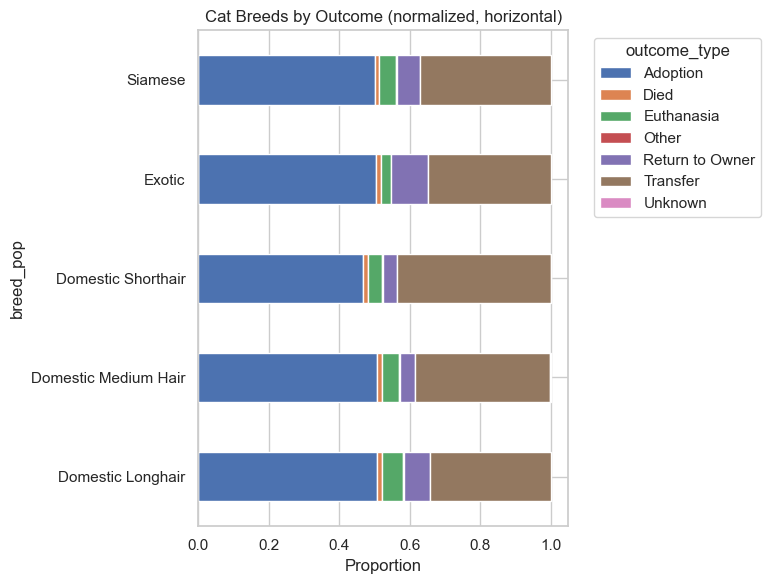

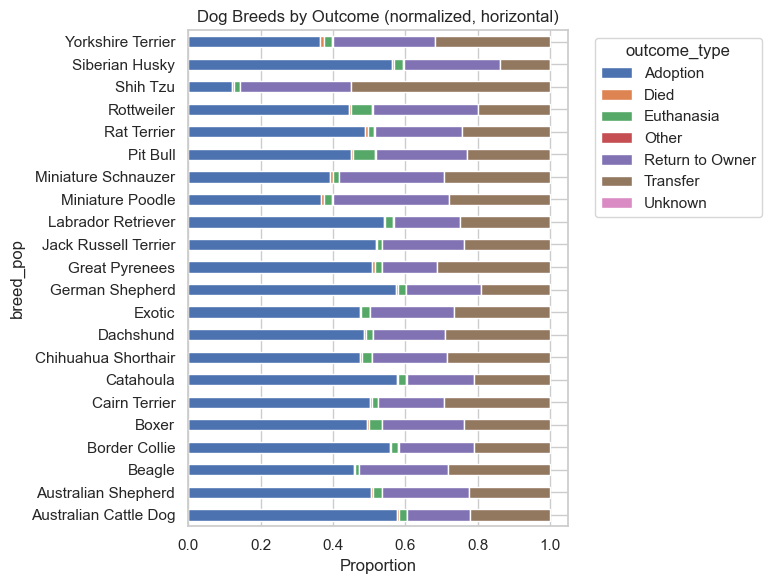

In [559]:
# ---------- HELPER: normalized stacked bar (horizontal version) ----------
def normalized_stacked_bar(data, x, hue, title, order_x=None, order_hue=None):
    ctab = pd.crosstab(data[x], data[hue], normalize='index')
    if order_x is not None:
        order_x = [o for o in order_x if o in ctab.index]
        ctab = ctab.reindex(order_x)
    ctab.plot(kind='barh', stacked=True, figsize=(8,6))
    plt.title(title)
    plt.xlabel("Proportion")   # now x-axis is proportion
    plt.ylabel(x)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------- Outcome by breed, separately for Cats and Dogs ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()

# (A) Cats
normalized_stacked_bar(
    data=cats,
    x='breed_pop',
    hue='outcome_type',
    title="Cat Breeds by Outcome (normalized, horizontal)"
)

# (B) Dogs
normalized_stacked_bar(
    data=dogs,
    x='breed_pop',
    hue='outcome_type',
    title="Dog Breeds by Outcome (normalized, horizontal)"
)

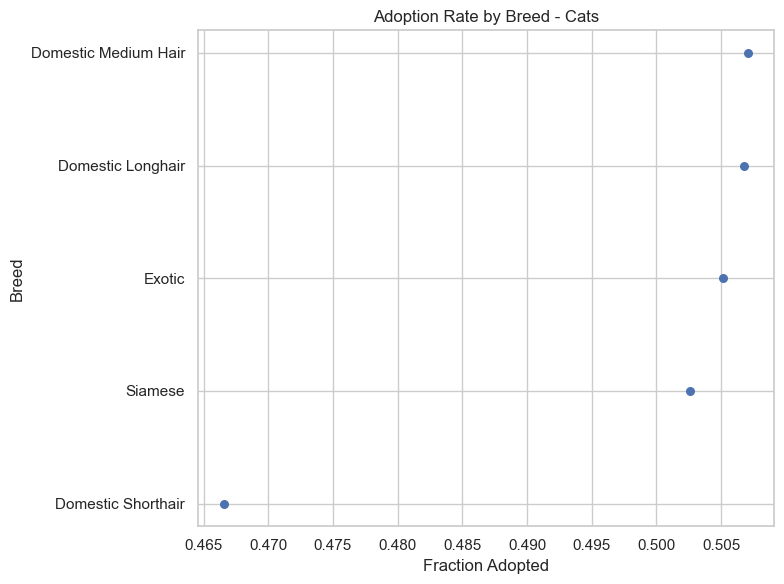

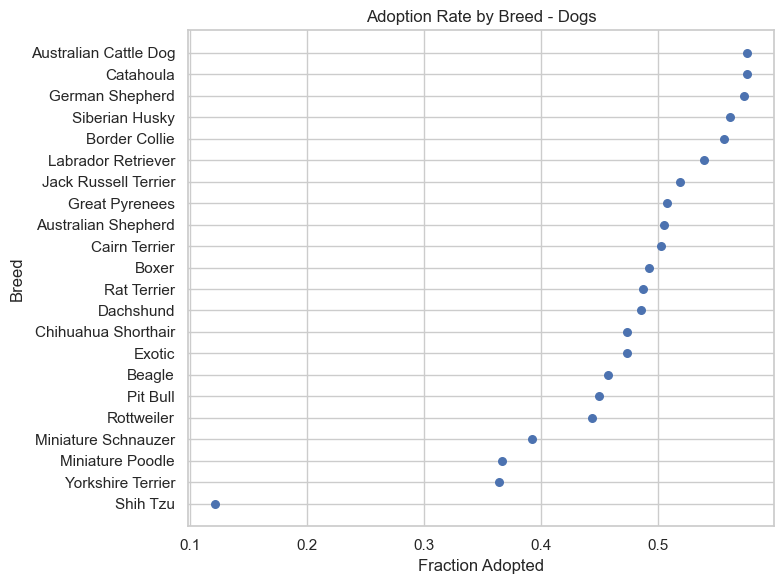

In [560]:
import matplotlib.pyplot as plt

# ---------- Cleveland dot plots: Adoption fraction by breed ----------
def fraction_by_outcome(data, group_col, outcome_col, outcome_value):
    # counts per group x outcome
    g = (data.groupby([group_col, outcome_col])
               .size()
               .reset_index(name='n'))
    # fraction within group
    g['frac'] = g.groupby(group_col)['n'].transform(lambda x: x / x.sum())
    # keep just the chosen outcome
    g = g[g[outcome_col] == outcome_value].copy()
    # order by fraction
    g = g.sort_values('frac', ascending=True)
    return g[[group_col, 'frac']]

# ---------- Outcome by breed, separately for Cats and Dogs ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()

# Cats: adoption fraction by breed
cats_adopt = fraction_by_outcome(
    cats, group_col='breed_pop', outcome_col='outcome_type', outcome_value='Adoption'
)

plt.figure(figsize=(8,6))
plt.scatter(cats_adopt['frac'], cats_adopt['breed_pop'], s=30)
plt.title("Adoption Rate by Breed - Cats")
plt.xlabel("Fraction Adopted")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()

# Dogs: adoption fraction by breed
dogs_adopt = fraction_by_outcome(
    dogs, group_col='breed_pop', outcome_col='outcome_type', outcome_value='Adoption'
)

plt.figure(figsize=(8,6))
plt.scatter(dogs_adopt['frac'], dogs_adopt['breed_pop'], s=30)
plt.title("Adoption Rate by Breed - Dogs")
plt.xlabel("Fraction Adopted")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()


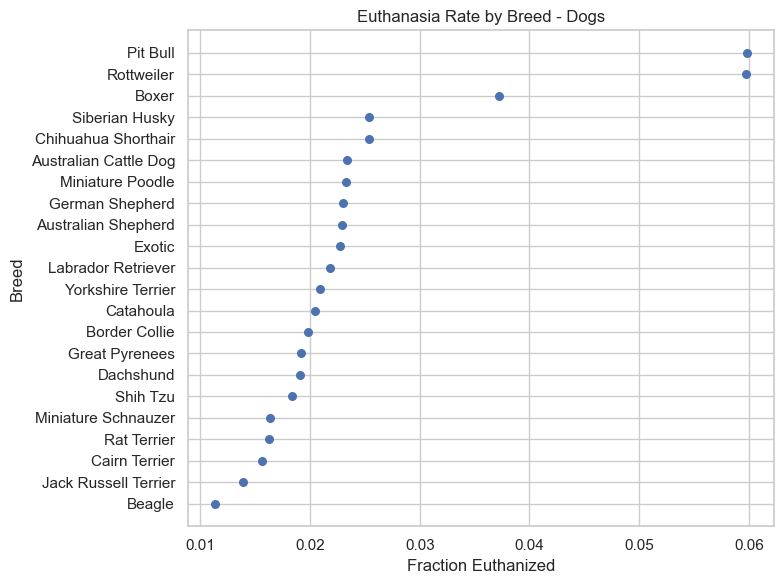

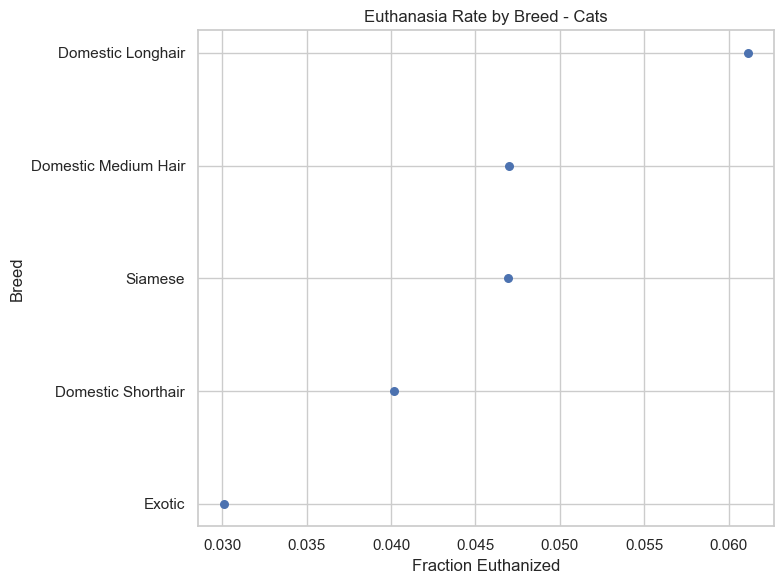

In [561]:
# Dogs: euthanasia fraction by breed
dogs_euth = fraction_by_outcome(
    dogs, group_col='breed_pop', outcome_col='outcome_type', outcome_value='Euthanasia'
)

plt.figure(figsize=(8,6))
plt.scatter(dogs_euth['frac'], dogs_euth['breed_pop'], s=30)
plt.title("Euthanasia Rate by Breed - Dogs")
plt.xlabel("Fraction Euthanized")
plt.ylabel("Breed")
plt.tight_layout()
plt.savefig("dogs_euthanasia_rate_by_breed.png", dpi=300)  # save figure
plt.show()

# Cats: euthanasia fraction by breed
cats_euth = fraction_by_outcome(
    cats, group_col='breed_pop', outcome_col='outcome_type', outcome_value='Euthanasia'
)

plt.figure(figsize=(8,6))
plt.scatter(cats_euth['frac'], cats_euth['breed_pop'], s=30)
plt.title("Euthanasia Rate by Breed - Cats")
plt.xlabel("Fraction Euthanized")
plt.ylabel("Breed")
plt.tight_layout()
plt.show()


In [562]:
print(merged_df['color'].value_counts().to_string())

color
Black/White                    14083
Black                          11711
Brown Tabby                     9022
White                           4949
Brown Tabby/White               4587
Orange Tabby                    4364
Brown/White                     4330
Tan/White                       3931
White/Black                     3746
Blue/White                      3677
Tan                             3437
Brown                           3273
Black/Tan                       2976
Black/Brown                     2843
Tricolor                        2823
Tortie                          2700
Blue                            2651
White/Brown                     2550
Calico                          2549
Blue Tabby                      2351
Brown/Black                     2301
Orange Tabby/White              2171
Brown Brindle/White             2105
White/Tan                       1966
Torbie                          1822
Red                             1345
Red/White                       

In [563]:
print(merged_df['color'].nunique())

616


# Visualizing color:

In [564]:
import numpy as np
import pandas as pd

# ---------- Simplify + Collapse Rare Colors ----------
def simplify_and_collapse_colors(df, col='color', new_col='Simple_color', threshold=300):
    out = df.copy()

    # Step 1: Simplify (take first token before '/')
    out[new_col] = out[col].apply(
        lambda c: np.nan if pd.isna(c) else str(c).split('/')[0].strip()
    )

    # Step 2: Collapse rare categories into "Other"
    counts = out[new_col].value_counts(dropna=False)
    keep = set(counts[counts > threshold].index)
    out[new_col] = np.where(out[new_col].isin(keep), out[new_col], 'Other')

    return out

# Apply to merged_df
merged_df = simplify_and_collapse_colors(merged_df, col='color', new_col='Simple_color', threshold=300)

# Quick check
print(merged_df['Simple_color'].value_counts())


Simple_color
Black            33040
White            17393
Brown Tabby      13776
Brown            10800
Tan               9148
Orange Tabby      6556
Blue              6538
Brown Brindle     3462
Blue Tabby        3458
Tricolor          3166
Red               3105
Tortie            2900
Calico            2786
Other             2362
Torbie            2209
Chocolate         1761
Cream Tabby       1561
Gray              1352
Cream             1322
Sable              973
Fawn               932
Lynx Point         871
Yellow             828
Buff               779
Gray Tabby         701
Seal Point         627
Blue Merle         609
Black Brindle      441
Orange             428
Flame Point        384
Black Tabby        335
Gold               327
Brown Merle        301
Name: count, dtype: int64


In [565]:
print(merged_df['Simple_color'].nunique())

33


In [566]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop', 'Simple_color'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

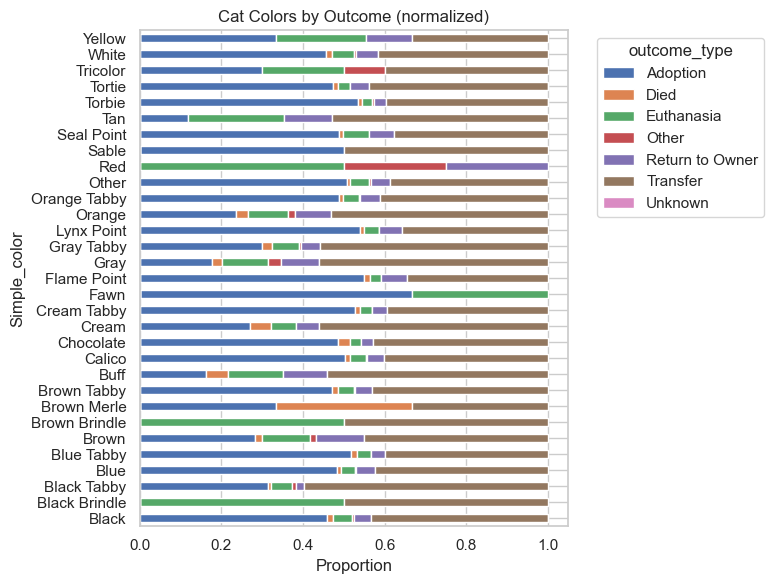

<Figure size 1200x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

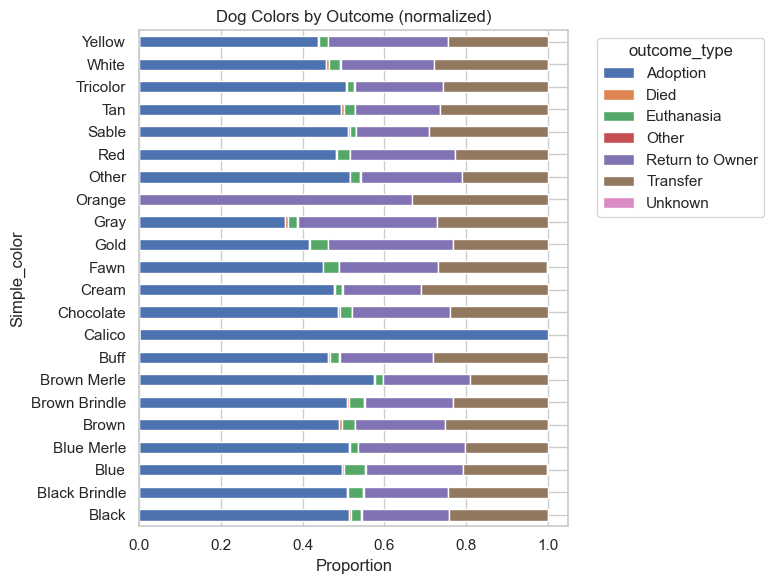

<Figure size 1200x800 with 0 Axes>

In [567]:
# Cats plot
plt.figure(figsize=(10,6))
normalized_stacked_bar(
    data=cats2,
    x='Simple_color',
    hue='outcome_type',
    title="Cat Colors by Outcome (normalized)",
)
plt.tight_layout()
plt.savefig("cats_colors_outcome.png", dpi=300)   # save as PNG (HD)
plt.savefig("cats_colors_outcome.pdf")            # also save as PDF (vector)
plt.show()

# Dogs plot
plt.figure(figsize=(10,6))
normalized_stacked_bar(
    data=dogs2,
    x='Simple_color',
    hue='outcome_type',
    title="Dog Colors by Outcome (normalized)",
)
plt.tight_layout()
plt.savefig("dogs_colors_outcome.png", dpi=300)
plt.savefig("dogs_colors_outcome.pdf")
plt.show()


In [568]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop', 'Simple_color'],
      dtype='object')

# Visualizing sex_upon_intake vs Outcome

In [569]:
# Fill NaN values with "Unknown"
merged_df['sex_upon_intake'] = merged_df['sex_upon_intake'].fillna("Unknown")

# Define mapping dictionaries
intactness_mapping = {
    'Intact Male': 'intact',
    'Intact Female': 'intact',
    'Neutered Male': 'not_intact',
    'Spayed Female': 'not_intact',
    'Unknown': 'unknown'
}

sex_mapping = {
    'Intact Male': 'male',
    'Intact Female': 'female',
    'Neutered Male': 'male',
    'Spayed Female': 'female',
    'Unknown': 'unknown'
}

# Apply mappings
merged_df['intactness'] = merged_df['sex_upon_intake'].map(intactness_mapping)
merged_df['sex'] = merged_df['sex_upon_intake'].map(sex_mapping)

# Quick check
print(merged_df[['sex_upon_intake', 'intactness', 'sex']].head(10))


  sex_upon_intake  intactness     sex
0   Neutered Male  not_intact    male
1   Neutered Male  not_intact    male
2   Neutered Male  not_intact    male
3   Spayed Female  not_intact  female
4   Intact Female      intact  female
5   Neutered Male  not_intact    male
6   Neutered Male  not_intact    male
7   Spayed Female  not_intact  female
8   Intact Female      intact  female
9   Spayed Female  not_intact  female


In [570]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop', 'Simple_color', 'intactness', 'sex'],
      dtype='object')

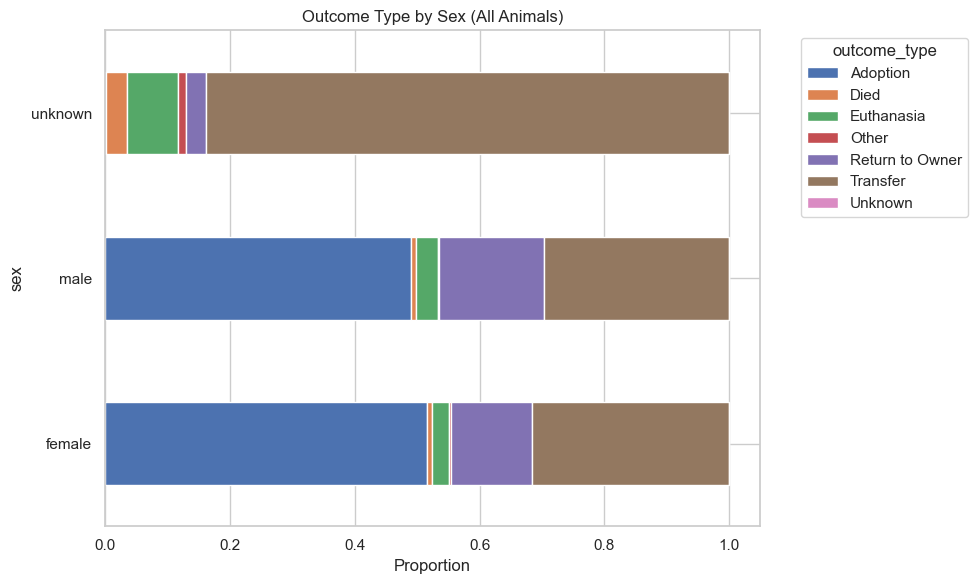

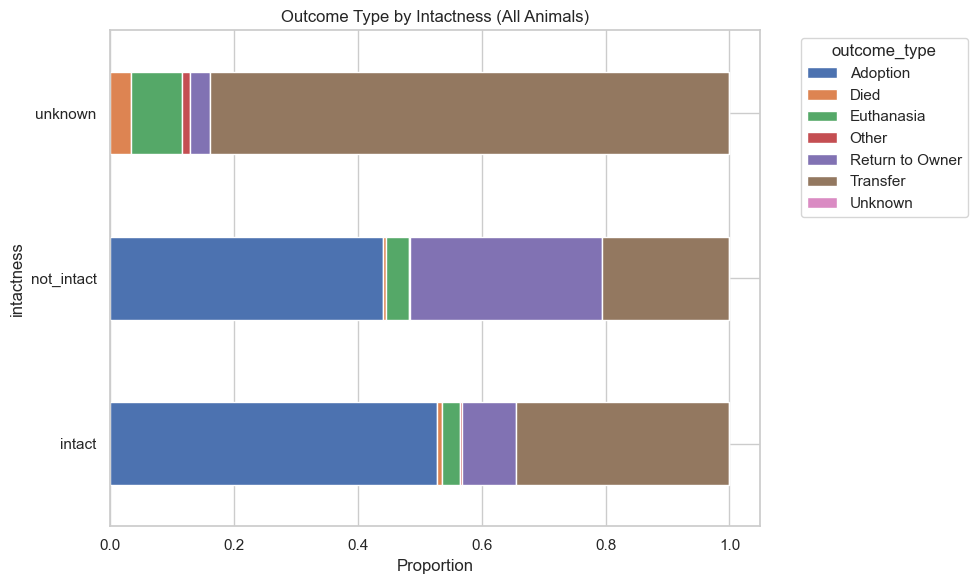

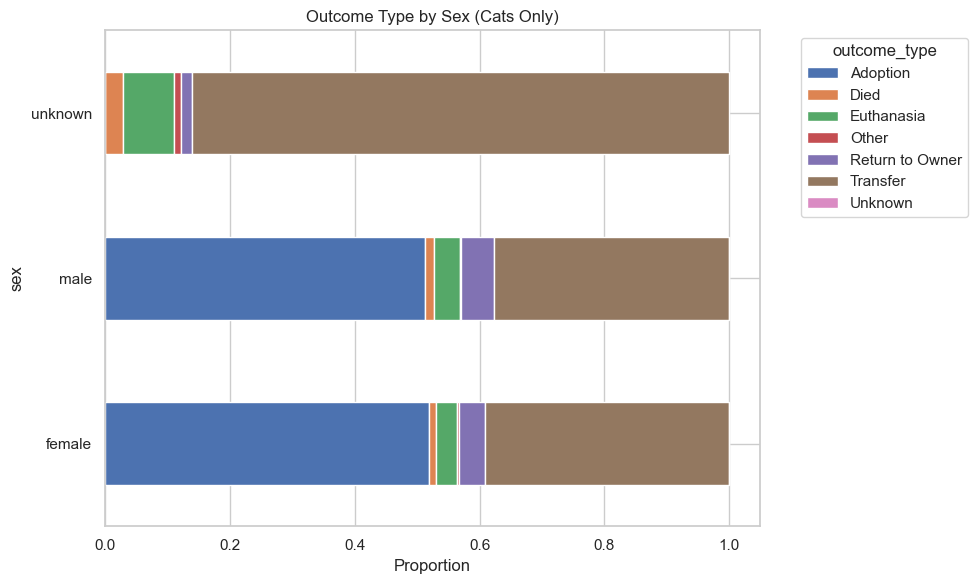

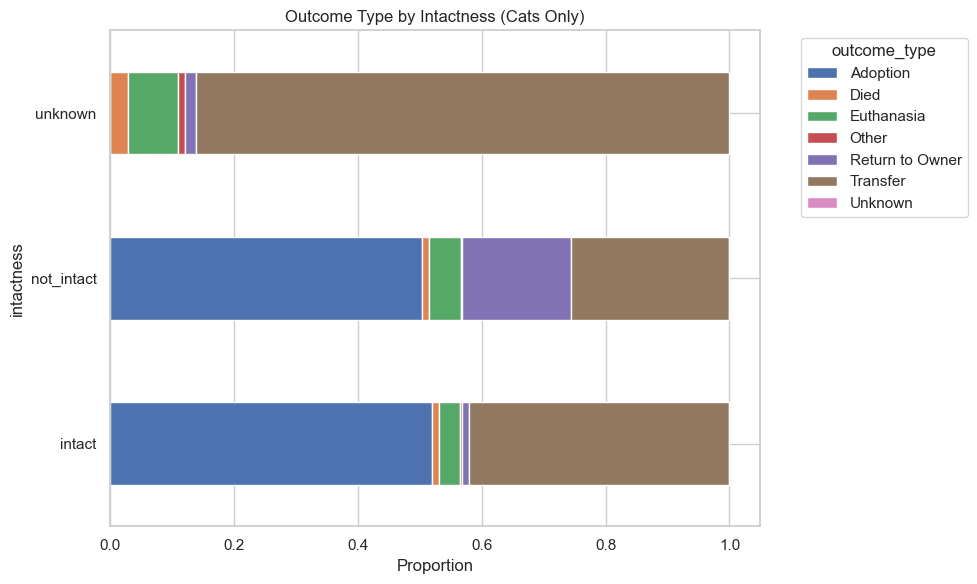

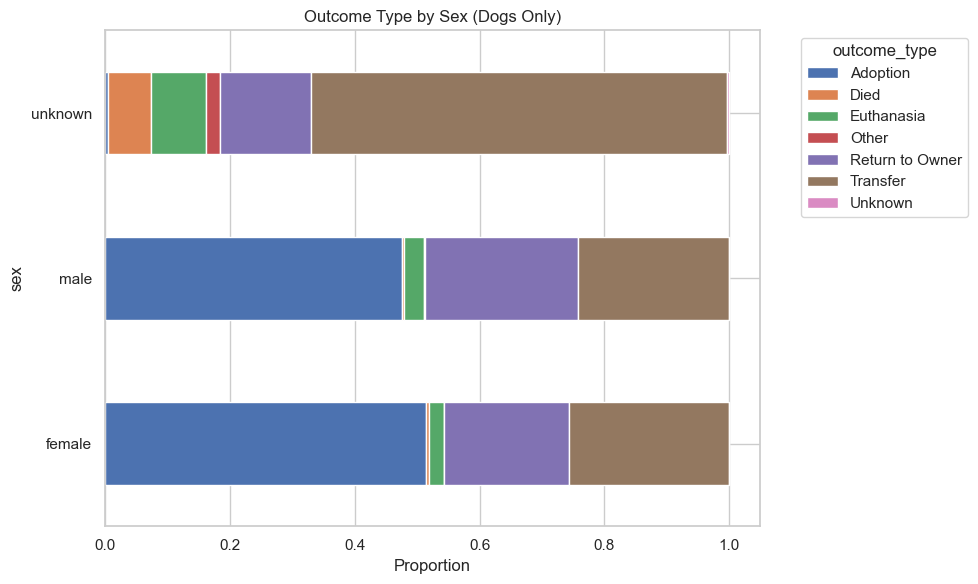

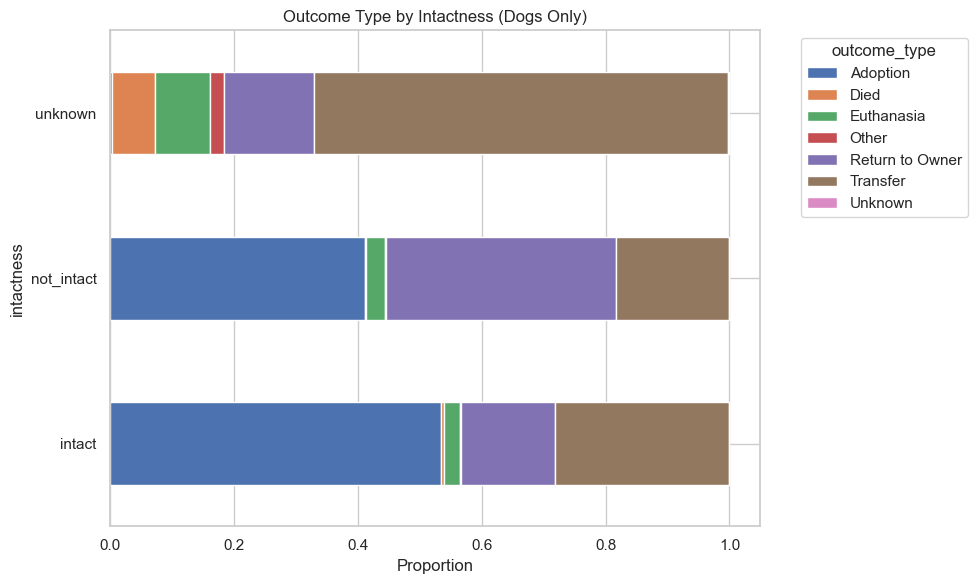

In [571]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Helper: stacked proportion plot ----------
def stacked_proportion_plot(data, x, hue, title):
    ctab = pd.crosstab(data[x], data[hue], normalize='index')
    ctab.plot(kind='barh', stacked=True, figsize=(10,6))
    plt.title(title)
    plt.xlabel("Proportion")
    plt.ylabel(x)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------- Combined (Cats + Dogs) ----------
stacked_proportion_plot(merged_df, x="sex", hue="outcome_type", 
                        title="Outcome Type by Sex (All Animals)")

stacked_proportion_plot(merged_df, x="intactness", hue="outcome_type", 
                        title="Outcome Type by Intactness (All Animals)")

# ---------- Cats only ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()

stacked_proportion_plot(cats, x="sex", hue="outcome_type", 
                        title="Outcome Type by Sex (Cats Only)")

stacked_proportion_plot(cats, x="intactness", hue="outcome_type", 
                        title="Outcome Type by Intactness (Cats Only)")

# ---------- Dogs only ----------
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()

stacked_proportion_plot(dogs, x="sex", hue="outcome_type", 
                        title="Outcome Type by Sex (Dogs Only)")

stacked_proportion_plot(dogs, x="intactness", hue="outcome_type", 
                        title="Outcome Type by Intactness (Dogs Only)")


# intake_type vs Outcome:

In [572]:
merged_df['intake_type'].value_counts()

intake_type
Stray                 96589
Owner Surrender       28928
Public Assist          7903
Abandoned              1575
Euthanasia Request      235
Wildlife                  1
Name: count, dtype: int64

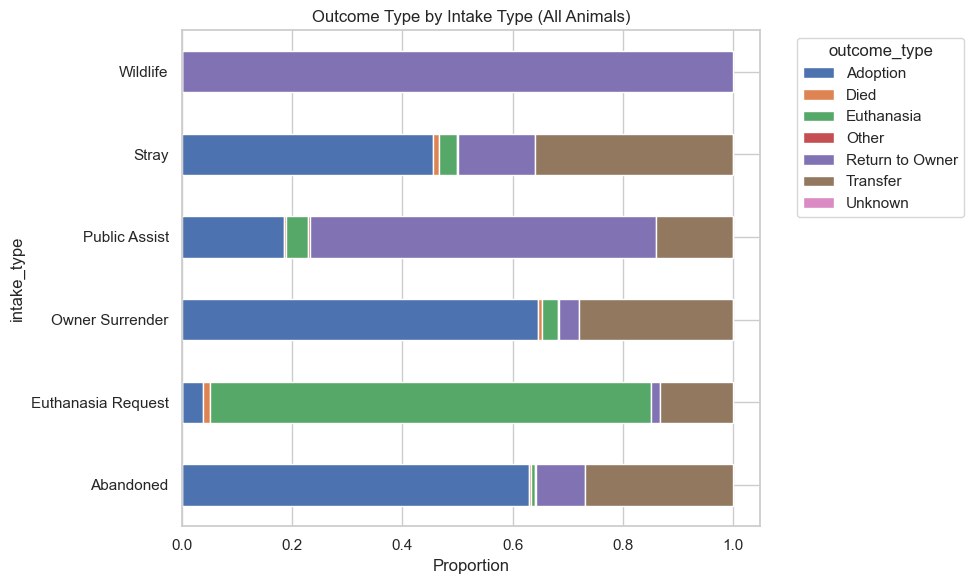

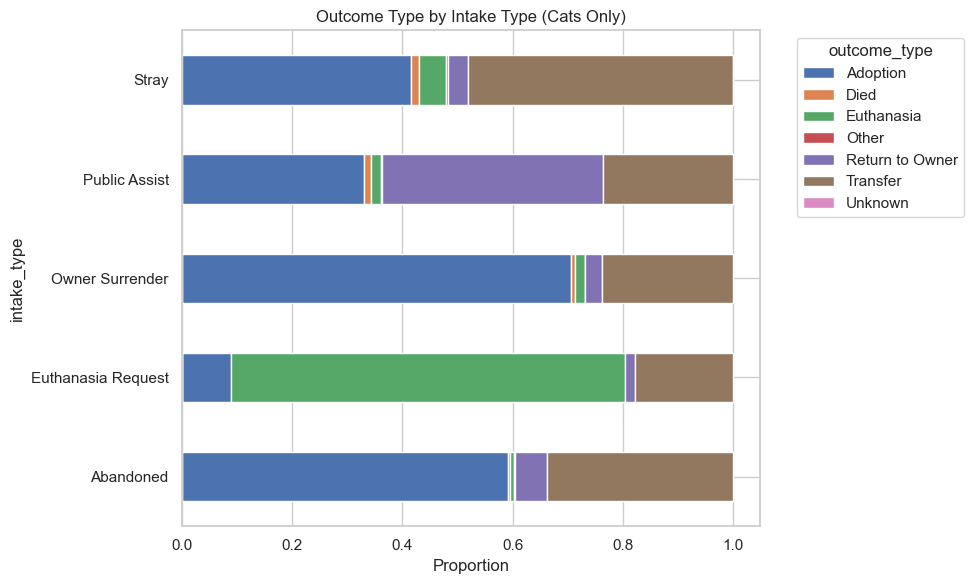

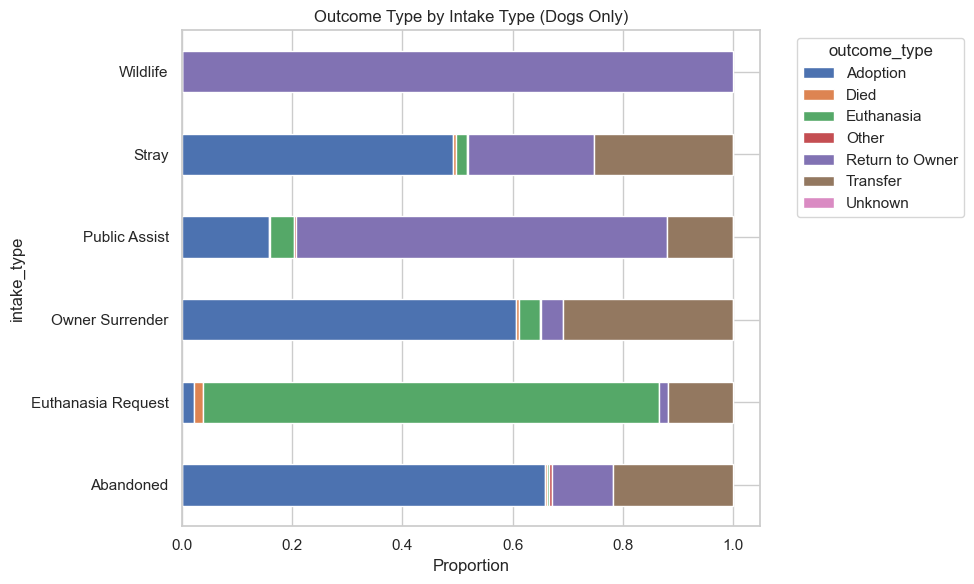

In [573]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helper function ----------
def stacked_proportion_plot(data, x, hue, title, horizontal=False):
    # Crosstab → normalize rows
    ctab = pd.crosstab(data[x], data[hue], normalize='index')
    if horizontal:
        ctab.plot(kind='barh', stacked=True, figsize=(10,6))
        plt.xlabel("Proportion")
        plt.ylabel(x)
    else: 
        ctab.plot(kind='bar', stacked=True, figsize=(10,6))
        plt.ylabel("Proportion")
        plt.xlabel(x)
    plt.title(title)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------- All animals ----------
stacked_proportion_plot(
    merged_df,
    x="intake_type",
    hue="outcome_type",
    title="Outcome Type by Intake Type (All Animals)",
    horizontal=True
)

# ---------- Cats only ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
stacked_proportion_plot(
    cats,
    x="intake_type",
    hue="outcome_type",
    title="Outcome Type by Intake Type (Cats Only)",
    horizontal=True
)

# ---------- Dogs only ----------
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()
stacked_proportion_plot(
    dogs,
    x="intake_type",
    hue="outcome_type",
    title="Outcome Type by Intake Type (Dogs Only)",
    horizontal=True
)


# Intake condition vs outcome_type:

In [574]:
merged_df['intake_condition'].value_counts()

intake_condition
Normal        115100
Injured         8309
Sick            5428
Nursing         3067
Neonatal        1584
Medical          509
Aged             478
Other            290
Pregnant         133
Feral            122
Med Attn          76
Behavior          60
Unknown           23
Med Urgent        21
Neurologic        11
Parvo             11
Space              4
Agonal             3
Panleuk            1
Congenital         1
Name: count, dtype: int64

In [575]:
merged_df['is_healthy'] = (merged_df['intake_condition'] == "Normal").astype(int)
print(merged_df[['intake_condition','is_healthy']])

       intake_condition  is_healthy
0                Normal           1
1                Normal           1
2               Injured           0
3                  Aged           0
4                Normal           1
...                 ...         ...
135226         Neonatal           0
135227         Neonatal           0
135228         Neonatal           0
135229           Normal           1
135230          Injured           0

[135231 rows x 2 columns]


In [576]:
merged_df['is_healthy'].value_counts()

is_healthy
1    115100
0     20131
Name: count, dtype: int64

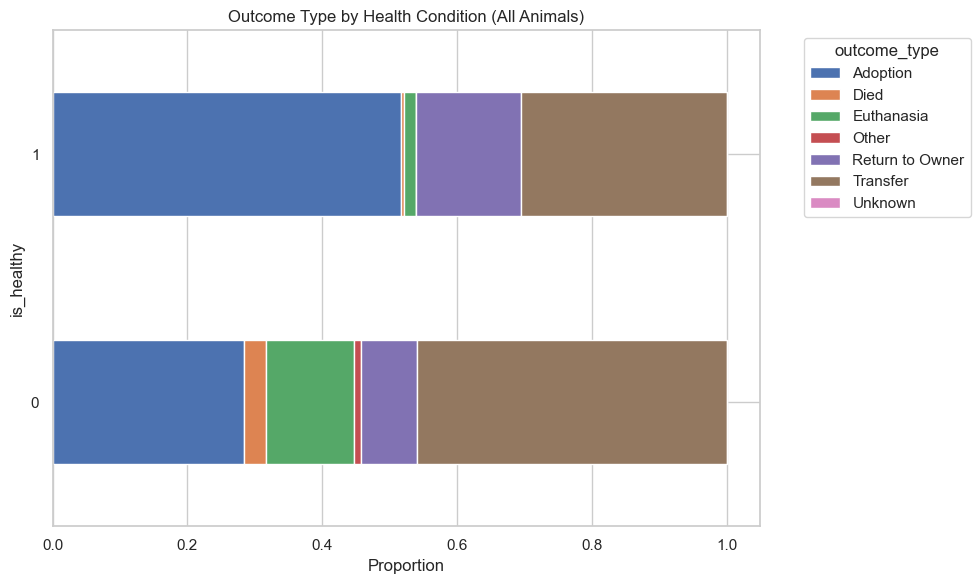

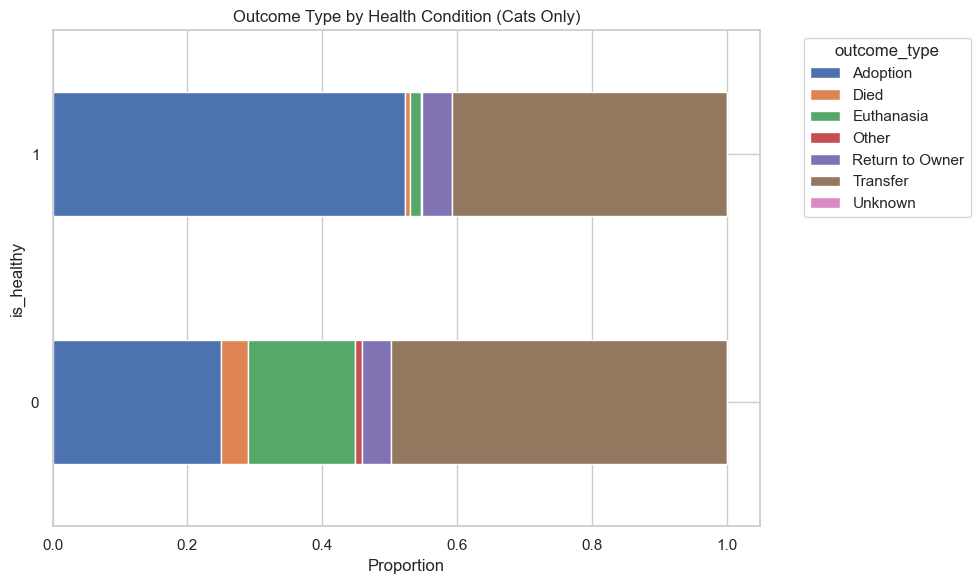

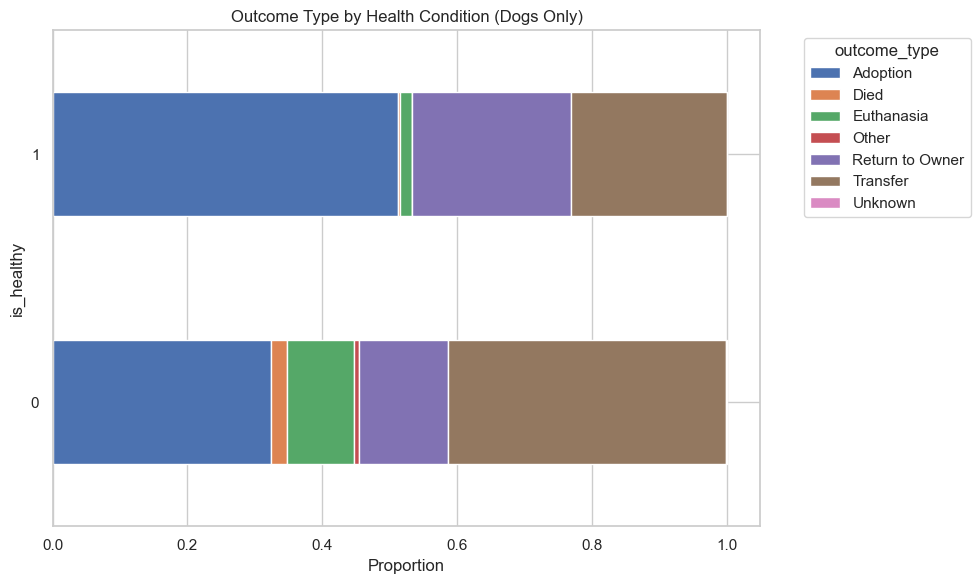

In [577]:
# ---------- All animals ----------
stacked_proportion_plot(
    merged_df,
    x="is_healthy",
    hue="outcome_type",
    title="Outcome Type by Health Condition (All Animals)",
    horizontal=True
)

# ---------- Cats only ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
stacked_proportion_plot(
    cats,
    x="is_healthy",
    hue="outcome_type",
    title="Outcome Type by Health Condition (Cats Only)",
    horizontal=True
)

# ---------- Dogs only ----------
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()
stacked_proportion_plot(
    dogs,
    x="is_healthy",
    hue="outcome_type",
    title="Outcome Type by Health Condition (Dogs Only)",
    horizontal=True
)


In [578]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop', 'Simple_color', 'intactness', 'sex',
       'is_healthy'],
      dtype='object')

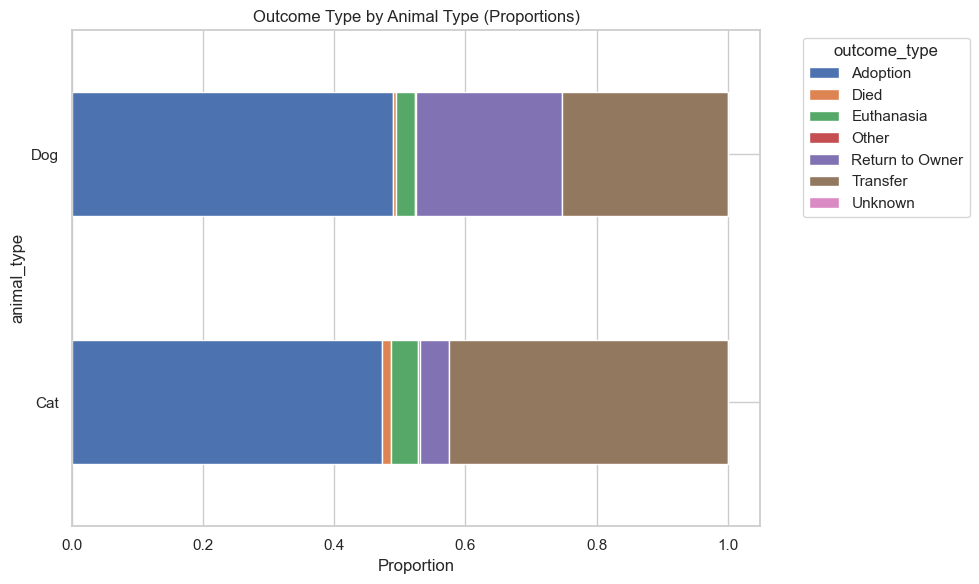

In [579]:
# ---------- Animal Type vs Outcome ----------
stacked_proportion_plot(
    merged_df,
    x="animal_type",
    hue="outcome_type",
    title="Outcome Type by Animal Type (Proportions)",
    horizontal=True
)


# HasName vs Outcome:

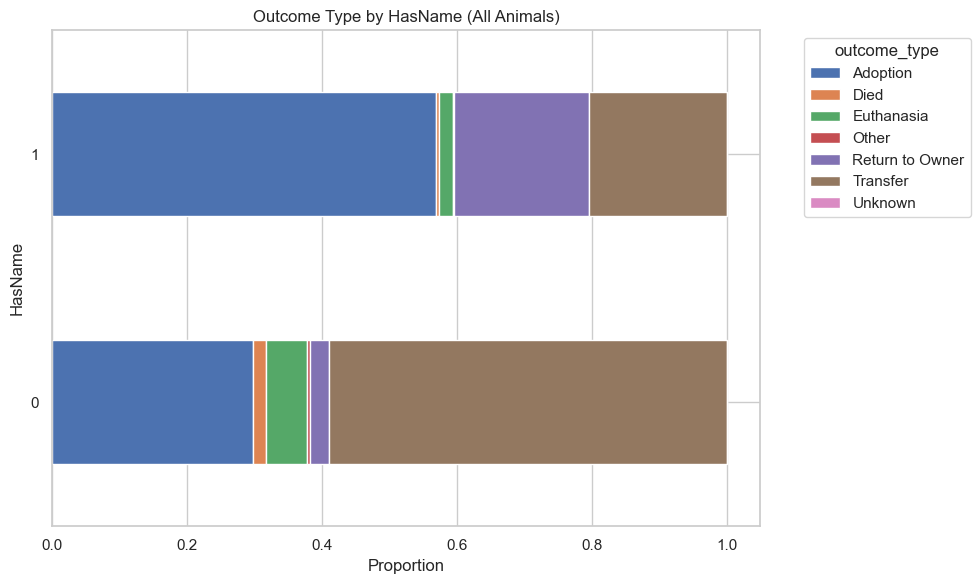

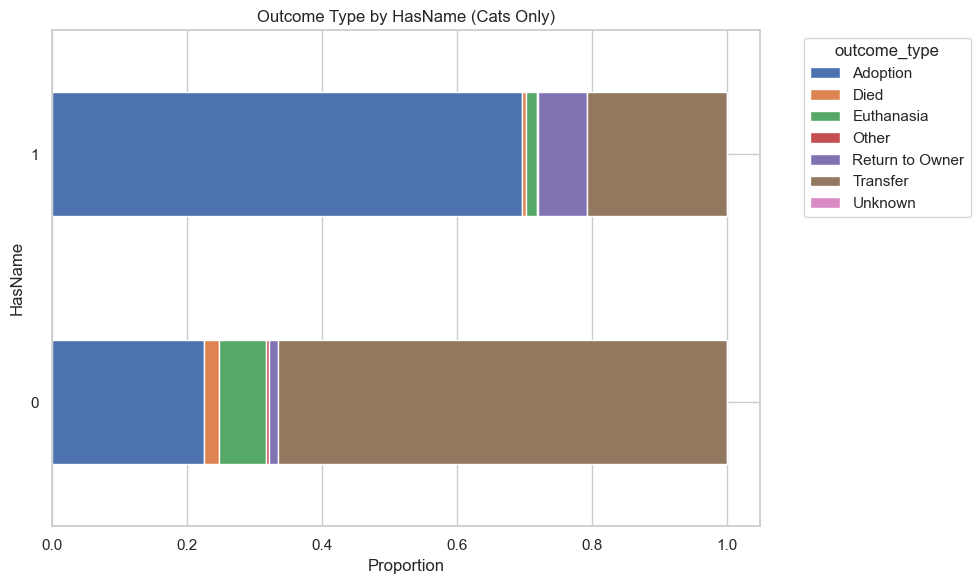

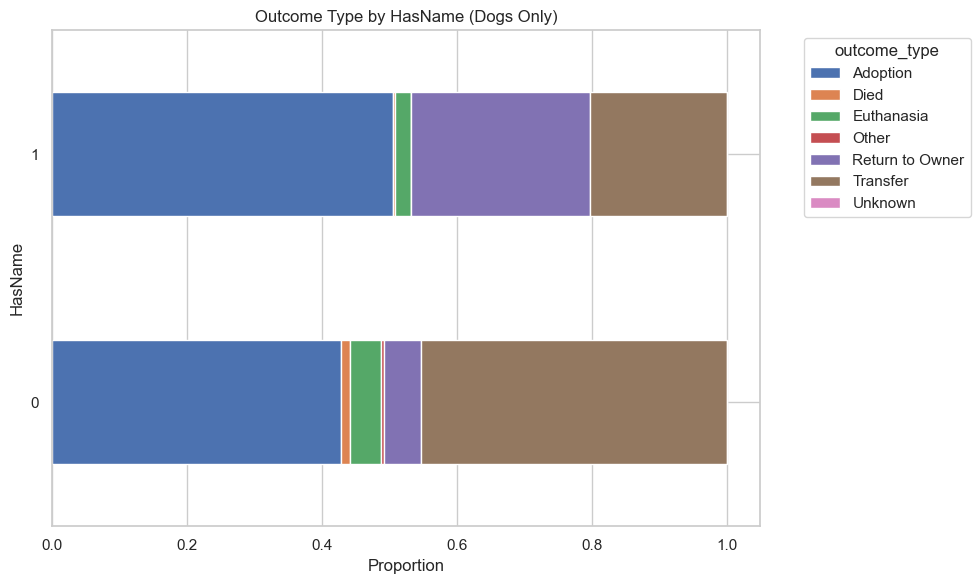

In [580]:
# ---------- All animals ----------
stacked_proportion_plot(
    merged_df,
    x="HasName",
    hue="outcome_type",
    title="Outcome Type by HasName (All Animals)",
    horizontal=True
)

# ---------- Cats only ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
stacked_proportion_plot(
    cats,
    x="HasName",
    hue="outcome_type",
    title="Outcome Type by HasName (Cats Only)",
    horizontal=True
)

# ---------- Dogs only ----------
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()
stacked_proportion_plot(
    dogs,
    x="HasName",
    hue="outcome_type",
    title="Outcome Type by HasName (Dogs Only)",
    horizontal=True
)


In [581]:
# age_days visualized

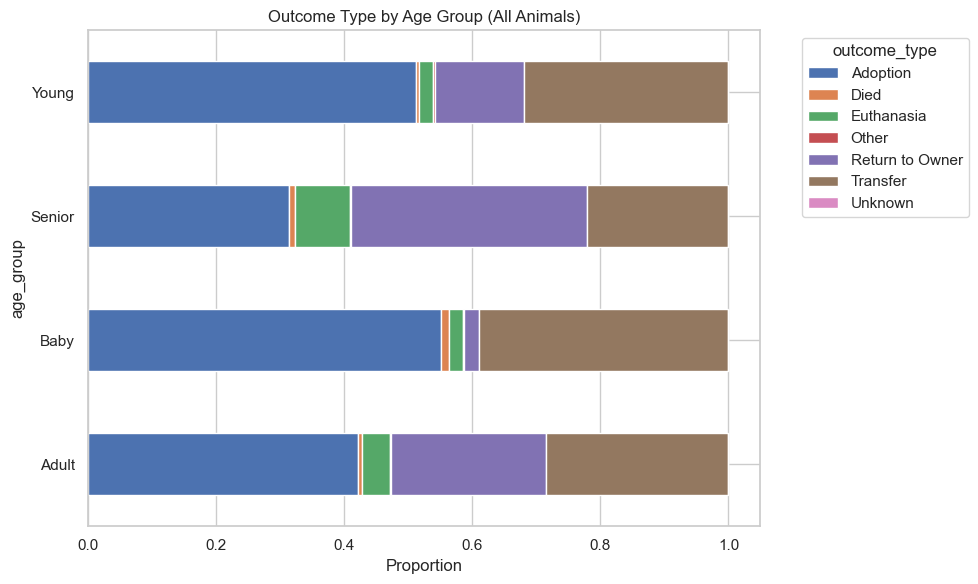

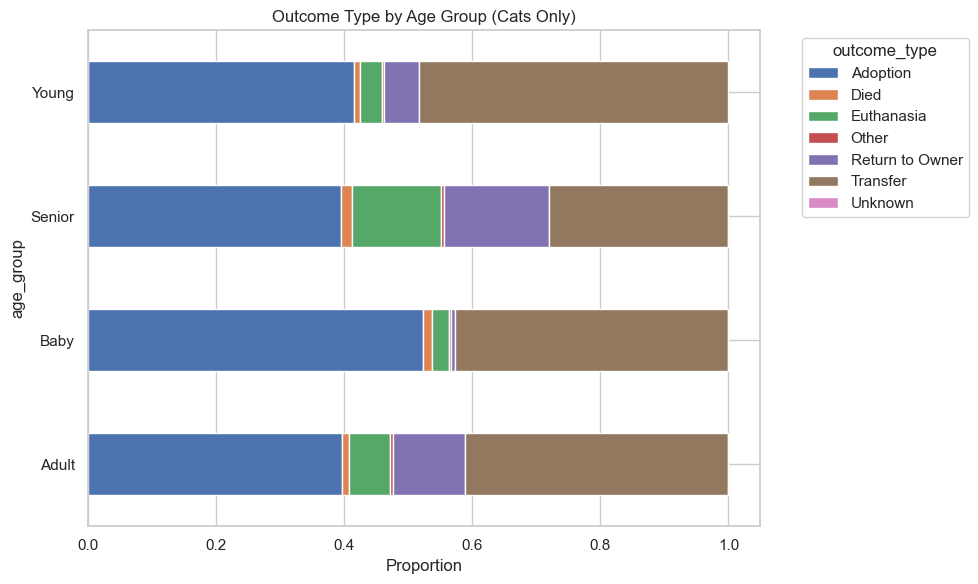

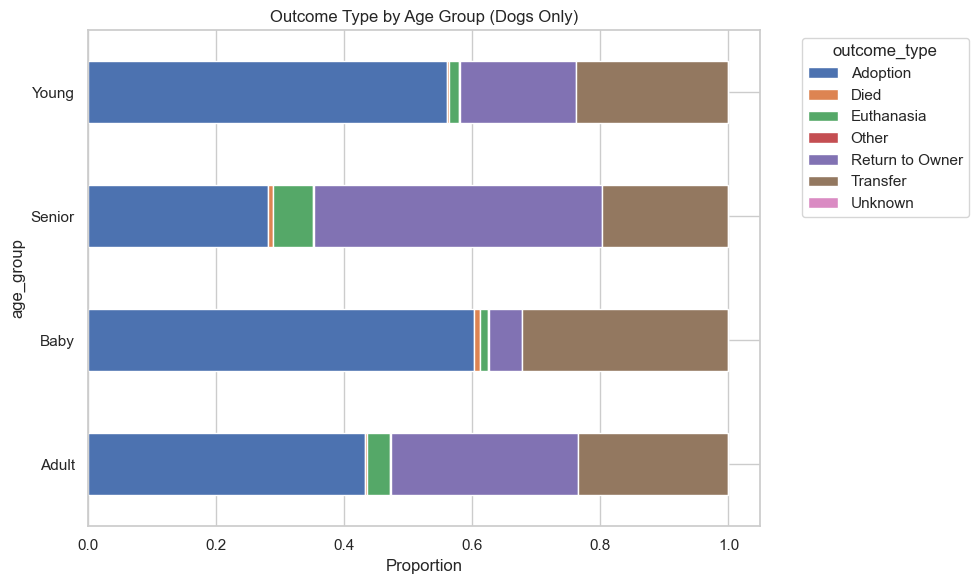

In [582]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Age categories ----------
def age_category(days):
    if days < 180:   # ~0-6 months
        return "Baby"
    elif days < 730:  # ~6 months - 2 years
        return "Young"
    elif days < 2555: # ~2 - 7 years
        return "Adult"
    else:             # 7+ years
        return "Senior"

merged_df['age_group'] = merged_df['age_days'].apply(age_category)

# ---------- Helper function ----------
def stacked_proportion_plot(data, x, hue, title, horizontal=True):
    ctab = pd.crosstab(data[x], data[hue], normalize='index')
    if horizontal:
        ctab.plot(kind='barh', stacked=True, figsize=(10,6))
        plt.xlabel("Proportion")
        plt.ylabel(x)
    else:
        ctab.plot(kind='bar', stacked=True, figsize=(10,6))
        plt.ylabel("Proportion")
        plt.xlabel(x)
    plt.title(title)
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ---------- All animals ----------
stacked_proportion_plot(
    merged_df,
    x="age_group",
    hue="outcome_type",
    title="Outcome Type by Age Group (All Animals)",
    horizontal=True
)

# ---------- Cats ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
stacked_proportion_plot(
    cats,
    x="age_group",
    hue="outcome_type",
    title="Outcome Type by Age Group (Cats Only)",
    horizontal=True
)

# ---------- Dogs ----------
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()
stacked_proportion_plot(
    dogs,
    x="age_group",
    hue="outcome_type",
    title="Outcome Type by Age Group (Dogs Only)",
    horizontal=True
)


In [583]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop', 'Simple_color', 'intactness', 'sex', 'is_healthy',
       'age_group'],
      dtype='object')

# Multiple visits or not vs outcome

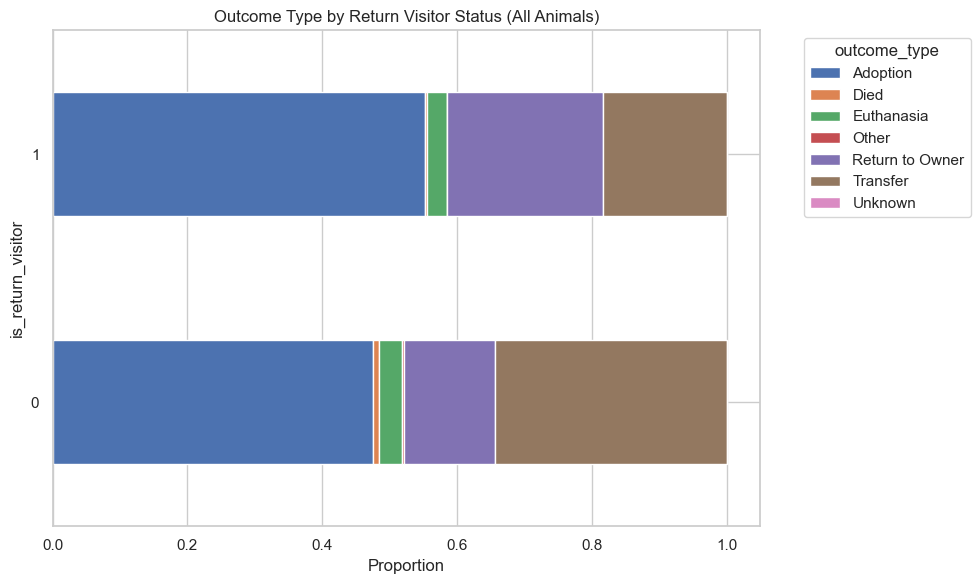

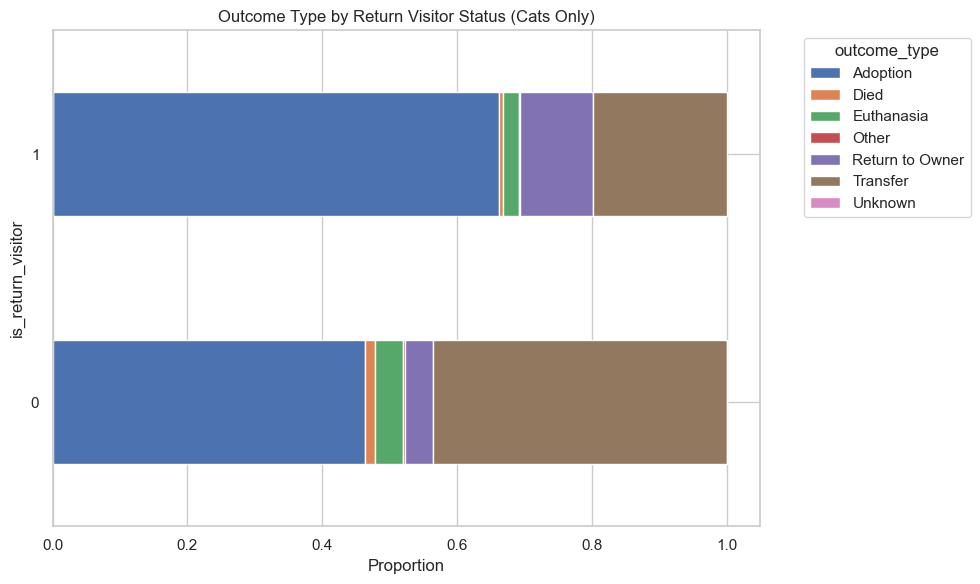

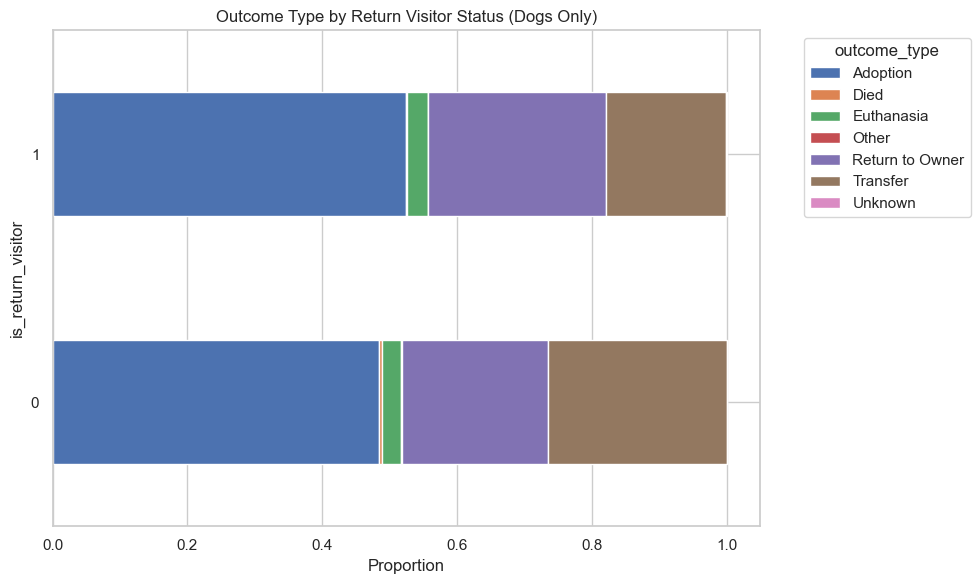

In [584]:
# Create binary feature: 0 for first-time, 1 for return visitors
merged_df['is_return_visitor'] = (merged_df['visit_count'] > 1).astype(int)

# ---------- All animals ----------
stacked_proportion_plot(
    merged_df,
    x="is_return_visitor",
    hue="outcome_type",
    title="Outcome Type by Return Visitor Status (All Animals)",
    horizontal=True
)

# ---------- Cats only ----------
cats = merged_df[merged_df['animal_type'].str.lower() == 'cat'].copy()
stacked_proportion_plot(
    cats,
    x="is_return_visitor",
    hue="outcome_type",
    title="Outcome Type by Return Visitor Status (Cats Only)",
    horizontal=True
)

# ---------- Dogs only ----------
dogs = merged_df[merged_df['animal_type'].str.lower() == 'dog'].copy()
stacked_proportion_plot(
    dogs,
    x="is_return_visitor",
    hue="outcome_type",
    title="Outcome Type by Return Visitor Status (Dogs Only)",
    horizontal=True
)


In [585]:
merged_df['is_return_visitor'].value_counts()

is_return_visitor
0    122059
1     13172
Name: count, dtype: int64

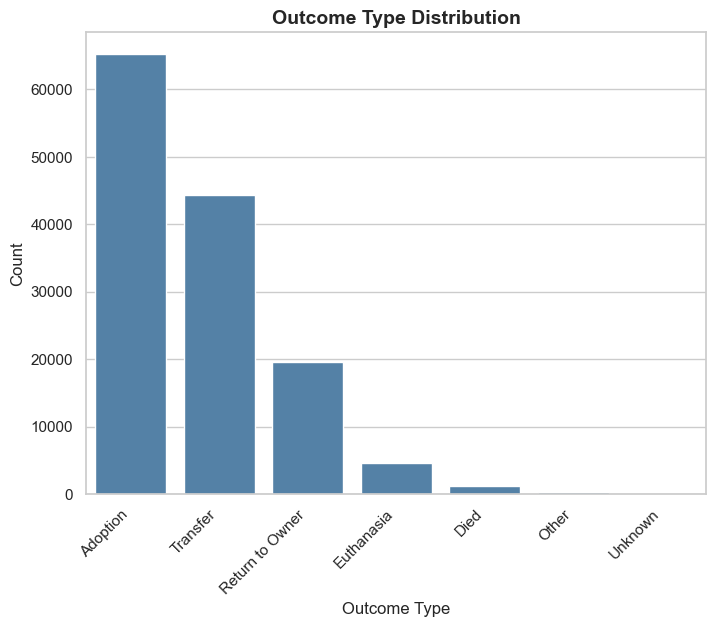

In [586]:
import matplotlib.pyplot as plt
import seaborn as sns

# Value counts for outcome_type
outcome_counts = merged_df['outcome_type'].value_counts()

# Plot (all bars one color)
plt.figure(figsize=(8,6))
sns.barplot(x=outcome_counts.index, 
            y=outcome_counts.values, 
            color="steelblue")   # single color

plt.title("Outcome Type Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Outcome Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()


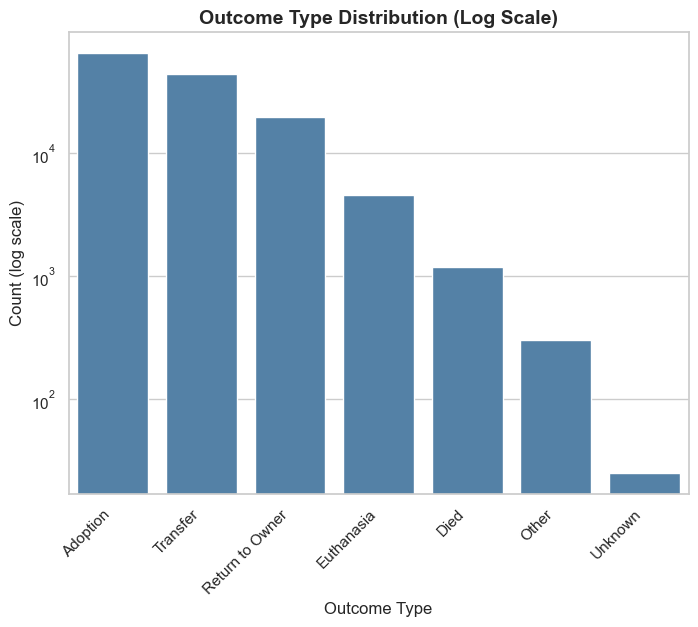

In [587]:
import matplotlib.pyplot as plt
import seaborn as sns

# Value counts
outcome_counts = merged_df['outcome_type'].value_counts()

# Plot with one color for all bars
plt.figure(figsize=(8,6))
sns.barplot(
    x=outcome_counts.index,
    y=outcome_counts.values,
    color="steelblue"   # pick any color, e.g. "skyblue", "gray", "#1f77b4"
)

plt.yscale("log")  # log scale
plt.title("Outcome Type Distribution (Log Scale)", fontsize=14, fontweight="bold")
plt.xlabel("Outcome Type", fontsize=12)
plt.ylabel("Count (log scale)", fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.show()


In [588]:
merged_df.columns

Index(['animal_id', 'sex_upon_intake', 'datetime_intake', 'visit_count',
       'intake_type', 'intake_condition', 'animal_type', 'breed', 'color',
       'outcome_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'breed_pop', 'Simple_color', 'intactness', 'sex', 'is_healthy',
       'age_group', 'is_return_visitor'],
      dtype='object')

In [589]:
len(merged_df.columns)

30

In [590]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


# let's separate the feature matrix X, and target variable y
y = merged_df['outcome_type']
# Drop target and identifier columns
X = merged_df.drop(columns=['outcome_type', 'animal_id','datetime_intake','breed','color','breed_pop'])

random_state = 42

# First split: Training vs (Validation + Test)
X_train, X_other, y_train, y_other = train_test_split(
    X, y,
    train_size=0.6,
    stratify=y,               # stratify to preserve class balance
    random_state=random_state
)

# Second split: Validation vs Test
X_val, X_test, y_val, y_test = train_test_split(
    X_other, y_other,
    train_size=0.5,
    stratify=y_other,         # stratify again on the reduced set
    random_state=random_state
)


print("**Balance with stratification:**")
print("Train:", np.unique(y_train, return_counts=True))
print("Validation:", np.unique(y_val, return_counts=True))
print("Test:", np.unique(y_test, return_counts=True))


**Balance with stratification:**
Train: (array(['Adoption', 'Died', 'Euthanasia', 'Other', 'Return to Owner',
       'Transfer', 'Unknown'], dtype=object), array([39134,   707,  2755,   182, 11778, 26567,    15]))
Validation: (array(['Adoption', 'Died', 'Euthanasia', 'Other', 'Return to Owner',
       'Transfer', 'Unknown'], dtype=object), array([13044,   236,   918,    61,  3926,  8856,     5]))
Test: (array(['Adoption', 'Died', 'Euthanasia', 'Other', 'Return to Owner',
       'Transfer', 'Unknown'], dtype=object), array([13045,   235,   919,    61,  3926,  8856,     5]))


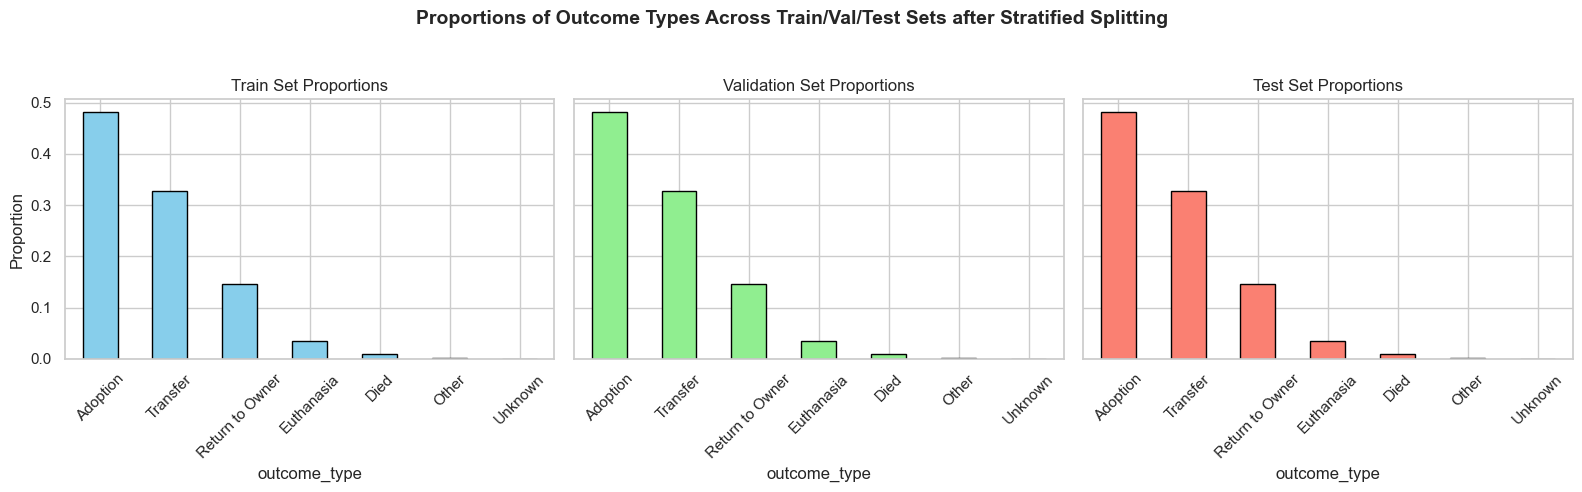

In [591]:
import matplotlib.pyplot as plt

def plot_stratified_proportions(y_train, y_val, y_test):
    fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

    # Train proportions
    y_train.value_counts(normalize=True).plot(
        kind='bar', ax=axes[0], color='skyblue', edgecolor='black'
    )
    axes[0].set_title("Train Set Proportions")
    axes[0].set_ylabel("Proportion")
    axes[0].tick_params(axis='x', rotation=45)

    # Validation proportions
    y_val.value_counts(normalize=True).plot(
        kind='bar', ax=axes[1], color='lightgreen', edgecolor='black'
    )
    axes[1].set_title("Validation Set Proportions")
    axes[1].tick_params(axis='x', rotation=45)

    # Test proportions
    y_test.value_counts(normalize=True).plot(
        kind='bar', ax=axes[2], color='salmon', edgecolor='black'
    )
    axes[2].set_title("Test Set Proportions")
    axes[2].tick_params(axis='x', rotation=45)

    plt.suptitle("Proportions of Outcome Types Across Train/Val/Test Sets after Stratified Splitting", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run this after you define y_train, y_val, y_test
plot_stratified_proportions(y_train, y_val, y_test)


# Summary Statistics:

In [592]:
X.columns

Index(['sex_upon_intake', 'visit_count', 'intake_type', 'intake_condition',
       'animal_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'Simple_color', 'intactness', 'sex', 'is_healthy', 'age_group',
       'is_return_visitor'],
      dtype='object')

In [593]:
len(X.columns)

24

In [594]:
merged_df['intactness'].value_counts()

intactness
intact        93258
not_intact    36369
unknown        5604
Name: count, dtype: int64

In [638]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

# --- Features ---
onehot_ftrs = ['sex_upon_intake','intake_type','intake_condition','animal_type',
               'intake_month','intake_weekday','is_weekend','intake_season',
               'intake_am_pm','intake_part_of_day', 'HasName','Simple_breed','IsMix','Simple_color',
               'sex','is_return_visitor',  'is_healthy', 'intactness','intake_hour','intake_week','intake_quarter']

ordinal_ftrs = ['age_group']
ordinal_cats = [
    ['Baby', 'Young', 'Adult', 'Senior']   # age_group
]
std_ftrs = ['visit_count','age_days']

# --- Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('ordinal', OrdinalEncoder(categories=ordinal_cats), ordinal_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ]
)

# --- Pipeline (only preprocessing for now) ---
clf = Pipeline(steps=[('preprocessor', preprocessor)])

# --- Transform ---
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train.shape)
print(X_train_prep.shape)
print(X_val.shape)
print(X_val_prep.shape)
print(X_test.shape)
print(X_test_prep.shape)


(81138, 24)
(81138, 381)
(27046, 24)
(27046, 381)
(27047, 24)
(27047, 381)


In [596]:
y.value_counts()

outcome_type
Adoption           65223
Transfer           44279
Return to Owner    19630
Euthanasia          4592
Died                1178
Other                304
Unknown               25
Name: count, dtype: int64

In [597]:
X.columns

Index(['sex_upon_intake', 'visit_count', 'intake_type', 'intake_condition',
       'animal_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'Simple_color', 'intactness', 'sex', 'is_healthy', 'age_group',
       'is_return_visitor'],
      dtype='object')

In [598]:
X['sex_upon_intake'].value_counts()

sex_upon_intake
Intact Male      46903
Intact Female    46355
Neutered Male    19619
Spayed Female    16750
Unknown           5604
Name: count, dtype: int64

In [599]:
X['visit_count'].describe()

count    135231.000000
mean          1.126613
std           0.454904
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          33.000000
Name: visit_count, dtype: float64

In [600]:
X['intake_type'].value_counts()

intake_type
Stray                 96589
Owner Surrender       28928
Public Assist          7903
Abandoned              1575
Euthanasia Request      235
Wildlife                  1
Name: count, dtype: int64

In [601]:
X['intake_condition'].value_counts()

intake_condition
Normal        115100
Injured         8309
Sick            5428
Nursing         3067
Neonatal        1584
Medical          509
Aged             478
Other            290
Pregnant         133
Feral            122
Med Attn          76
Behavior          60
Unknown           23
Med Urgent        21
Neurologic        11
Parvo             11
Space              4
Agonal             3
Panleuk            1
Congenital         1
Name: count, dtype: int64

In [602]:
X['intake_condition'].nunique()

20

In [603]:
X_train['intake_condition'].nunique()

20

In [604]:
X_test['intake_condition'].nunique()

18

In [605]:
X_val['intake_condition'].nunique()

16

In [606]:
X.columns

Index(['sex_upon_intake', 'visit_count', 'intake_type', 'intake_condition',
       'animal_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'Simple_color', 'intactness', 'sex', 'is_healthy', 'age_group',
       'is_return_visitor'],
      dtype='object')

In [607]:
X['animal_type'].value_counts()

animal_type
Dog    76345
Cat    58886
Name: count, dtype: int64

In [608]:
X['HasName'].value_counts()

HasName
1    91879
0    43352
Name: count, dtype: int64

In [609]:
X['age_days'].describe()

count    135231.000000
mean        747.438073
std        1071.427815
min           0.000000
25%          60.000000
50%         365.000000
75%         730.000000
max        8760.000000
Name: age_days, dtype: float64

In [610]:
X['intake_month'].value_counts()

intake_month
May          13400
June         13276
October      12573
July         12286
August       11786
September    11543
April        10918
November     10528
January       9968
March         9928
December      9903
February      9122
Name: count, dtype: int64

In [611]:
X['intake_weekday'].value_counts()

intake_weekday
Monday       21263
Tuesday      21039
Wednesday    20779
Friday       20492
Thursday     20010
Saturday     17349
Sunday       14299
Name: count, dtype: int64

In [612]:
X['intake_week'].value_counts()

# Note: Normally we expect 52 weeks in a year, but ISO week numbering can produce week 53.
# This happens when the year has 366 days (leap year) or when Jan 1st / Dec 31st falls on a Thursday
# (or Wednesday in a leap year). In those cases, the extra days form a 53rd week.
# Example: our dataset shows 314 rows in week 53 due to this behavior.
# If strict 1–52 weeks are required, we can re-map week 53 into week 52 manually.

intake_week
23    3191
20    3172
25    3161
21    3104
22    3097
26    3027
28    2968
19    2966
41    2942
24    2916
29    2864
43    2853
35    2817
18    2814
40    2798
42    2760
27    2753
44    2747
17    2742
37    2722
32    2684
39    2676
45    2669
31    2651
33    2639
38    2631
36    2624
16    2615
30    2607
49    2592
34    2584
46    2495
15    2448
9     2379
14    2377
11    2347
2     2338
3     2314
8     2307
13    2298
50    2293
6     2284
47    2272
1     2271
10    2252
48    2250
7     2170
5     2153
12    2147
4     2145
51    2093
52    1898
53     314
Name: count, dtype: Int64

In [613]:
X.columns

Index(['sex_upon_intake', 'visit_count', 'intake_type', 'intake_condition',
       'animal_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'Simple_color', 'intactness', 'sex', 'is_healthy', 'age_group',
       'is_return_visitor'],
      dtype='object')

In [614]:
X['intake_hour'].value_counts()

intake_hour
11    21398
12    19232
13    16619
14    14441
15    14023
16    12620
17     9052
18     7575
10     6657
9      3186
8      2993
7      2529
19     1542
21      715
20      606
23      562
22      526
0       286
6       274
1       125
2        93
3        66
4        57
5        54
Name: count, dtype: int64

In [615]:
X['intake_quarter'].value_counts()

intake_quarter
2    37594
3    35615
4    33004
1    29018
Name: count, dtype: int64

In [616]:
X['is_weekend'].value_counts()

is_weekend
Weekday    103583
Weekend     31648
Name: count, dtype: int64

In [617]:
X['intake_season'].value_counts()

intake_season
Summer    37348
Fall      34644
Spring    34246
Winter    28993
Name: count, dtype: int64

In [618]:
X['intake_am_pm'].value_counts()

intake_am_pm
PM    97513
AM    37718
Name: count, dtype: int64

In [619]:
X['intake_part_of_day'].value_counts()

intake_part_of_day
Afternoon    76935
Morning      37091
Evening      18775
Night         2430
Name: count, dtype: int64

In [620]:
X['Simple_breed'].value_counts()

Simple_breed
Domestic Shorthair            49140
Labrador Retriever            10908
Pit Bull                      10874
Chihuahua Shorthair            8757
German Shepherd                5568
                              ...  
Kuvasz                           10
Saluki                           10
Affenpinscher                    10
Devon Rex                        10
Greater Swiss Mountain Dog       10
Name: count, Length: 187, dtype: int64

In [621]:
X['Simple_breed'].nunique()

187

In [622]:
X_train['Simple_breed'].nunique()

187

In [623]:
X_test['Simple_breed'].nunique()

183

In [624]:
X_val['Simple_breed'].nunique()

186

In [625]:
X.columns

Index(['sex_upon_intake', 'visit_count', 'intake_type', 'intake_condition',
       'animal_type', 'HasName', 'age_days', 'intake_month', 'intake_weekday',
       'intake_week', 'intake_hour', 'intake_quarter', 'is_weekend',
       'intake_season', 'intake_am_pm', 'intake_part_of_day', 'Simple_breed',
       'IsMix', 'Simple_color', 'intactness', 'sex', 'is_healthy', 'age_group',
       'is_return_visitor'],
      dtype='object')

In [626]:
X['IsMix'].value_counts()

IsMix
1    82676
0    52555
Name: count, dtype: int64

In [627]:
X['Simple_color'].value_counts()

Simple_color
Black            33040
White            17393
Brown Tabby      13776
Brown            10800
Tan               9148
Orange Tabby      6556
Blue              6538
Brown Brindle     3462
Blue Tabby        3458
Tricolor          3166
Red               3105
Tortie            2900
Calico            2786
Other             2362
Torbie            2209
Chocolate         1761
Cream Tabby       1561
Gray              1352
Cream             1322
Sable              973
Fawn               932
Lynx Point         871
Yellow             828
Buff               779
Gray Tabby         701
Seal Point         627
Blue Merle         609
Black Brindle      441
Orange             428
Flame Point        384
Black Tabby        335
Gold               327
Brown Merle        301
Name: count, dtype: int64

In [628]:
X['Simple_color'].nunique()

33

In [629]:
X_train['Simple_color'].nunique()

33

In [630]:
X_test['Simple_color'].nunique()

33

In [631]:
X_val['Simple_color'].nunique()

33

In [632]:
X['intactness'].value_counts()

intactness
intact        93258
not_intact    36369
unknown        5604
Name: count, dtype: int64

In [633]:
X['sex'].value_counts()

sex
male       66522
female     63105
unknown     5604
Name: count, dtype: int64

In [634]:
X['is_healthy'].value_counts()

is_healthy
1    115100
0     20131
Name: count, dtype: int64

In [635]:
X['age_group'].value_counts()

age_group
Baby      53045
Adult     40972
Young     29004
Senior    12210
Name: count, dtype: int64

In [636]:
X['is_return_visitor'].value_counts()

is_return_visitor
0    122059
1     13172
Name: count, dtype: int64

In [637]:
merged_df['datetime_intake'].describe()

count                           135231
mean     2018-12-13 20:48:41.229895936
min                2013-10-01 07:51:00
25%                2016-02-21 17:36:00
50%                2018-08-31 20:54:00
75%                2021-09-19 15:38:00
max                2025-05-02 20:27:00
Name: datetime_intake, dtype: object